# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [5]:
# When using Google Colab we want to mount the data drive
try:
    from google.colab import drive
    drive.mount('/content/drive')
    IN_COLAB = True
except:
    IN_COLAB = False


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# When using Google Colab we want copy the Kaggle API key and check kaggle version
if IN_COLAB:
    !cp -Rv /content/drive/MyDrive/workspace/arvato_data/.kaggle ~/ && chmod 600 ~/.kaggle/kaggle.json

'/content/drive/MyDrive/workspace/arvato_data/.kaggle/kaggle.json' -> '/root/.kaggle/kaggle.json'


In [7]:
kg_version = !pip show kaggle | grep Version
kg_version = kg_version[0].split()[1].split('.')
kg_version

['1', '5', '12']

In [8]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE

# modeling 
import lightgbm as lgb

# if kaggle API version greater than 1.5.0 load kaggle API:
if int(kg_version[1]) == 5 and int(kg_version[2]) > 0:
    from kaggle.api.kaggle_api_extended import KaggleApi
    kg_loaded = True
else:
    kg_loaded = False
    print("Kaggle module must be upgraded!")

# magic word for producing visualizations in notebook
%matplotlib inline

# Google Colab environment:
if IN_COLAB:
    # Get pandas version
    print("Pandas verion: ", pd.__version__)

Pandas verion:  1.1.5


## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

## Strategy for exploring the data:

* Load datasets. Initially load random samples, finally load the full datasets.
* Load excel information files.
* Get the attributes from excel files and compare them to the attributes apearing the datasets.
* Get the value pools for each known attribute in the excel files and check against the values for each attribute in the datasets.
* Replace the values outside the pools with NaNs.
* Replace values in the pools representing unknowns, missing, not given, etc. with NaNs.
* Explore NaNs, analysing and understanding missing values in the two datasets.
* Identify significance of categorical, ordinal attributes.

### Load data and excel files

In [9]:
# Assign path names to variables for easier manipulation later on.

azdias_file = "/content/drive/MyDrive/workspace/arvato_data/Udacity_AZDIAS_052018.csv" if IN_COLAB else "../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv"
customers_file = "/content/drive/MyDrive/workspace/arvato_data/Udacity_CUSTOMERS_052018.csv" if IN_COLAB else "../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv"
mailout_train_file = "/content/drive/MyDrive/workspace/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv" if IN_COLAB else "../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv"
mailout_test_file = "/content/drive/MyDrive/workspace/arvato_data/Udacity_MAILOUT_052018_TEST.csv" if IN_COLAB else "../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv"

# Files with information about the columns depicted in the csv files
dias_attrib = "/content/drive/MyDrive/workspace/arvato_data/DIAS Attributes - Values 2017.xlsx" if IN_COLAB else "DIAS Attributes - Values 2017.xlsx"
dias_info = "/content/drive/MyDrive/workspace/arvato_data/DIAS Information Levels - Attributes 2017.xlsx" if IN_COLAB else "DIAS Information Levels - Attributes 2017.xlsx"

# Kaggle submission file
kg_submission = "/content/drive/MyDrive/workspace/arvato_data/" if IN_COLAB else ""
# Kaggle competition
kg_competition = 'udacity-arvato-identify-customers'

We will create a function to load a sample of the datasets to speed things up during the data exploration phase particularly for the larger azdias dataset. This will reduce the memory used for holding the whole dataset initially, but also greatly improve the speed of calculations when exploring and cleaning the data. We will later use the whole dataset for best results.


In [10]:
def get_df_sample(n_samples, seed=None, *args, **kwargs):
    """Load a random sample out of an input csv file or the whole file.

    Args:
        n_samples (int): Size of sample (number of rows) to randomly load from the input file.
        args, kwargs: Pass arguments and keword arguments as in pandas `read_csv` method.
        Ref: https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html

    Returns:
        The dataframe loaded from the input file of n_samples rows
    
    Reference:
        Stack Overflow - `Read a small random sample from a big CSV file into a Python data frame`:
        https://stackoverflow.com/a/61631765/10074873
        Pandas - `Iterating through files chunk by chunk`:
        https://pandas.pydata.org/pandas-docs/stable/user_guide/io.html#iterating-through-files-chunk-by-chunk
        Numpy - `Random Generator`:
        https://numpy.org/doc/stable/reference/random/generator.html#random-generator
    """
    rng = np.random.default_rng(seed=seed)

    samples_reader = pd.read_csv(*args, **kwargs)
    df = samples_reader.get_chunk(n_samples)

    for chunk in samples_reader:
        chunk.index = rng.integers(n_samples, size=len(chunk))
        df.loc[chunk.index] = chunk
    
    return df


* Read first the attributes as strings, to get the categories and then use that to read them directly as categorical.

In [11]:
# Set the desired sample size
sample_size = 200000

# Set to `True` to go through all the cells.
RUN_ALL = False

In [12]:
if RUN_ALL:
    # Try loading a sample
    azdias_try1 = get_df_sample(sample_size, 42, azdias_file, sep=';', chunksize=256000)

    azdias_try1.head()

In [13]:
if RUN_ALL:
    # Check the types of columns
    azdias_try1.dtypes.value_counts()

In [14]:
if RUN_ALL:
    # Check `object` columns
    azdias_try1.select_dtypes(include=object).head()

####Check columns 18, 19 that produced warnings when reading csv data

In [15]:
if RUN_ALL:
    # Check the two columns to identify why pandas "complained" about mixed types
    azdias_try1_1819 = azdias_try1.iloc[:,[18, 19]]

    azdias_try1_1819.columns

The two attributes are `'CAMEO_DEUG_2015', 'CAMEO_INTL_2015'`. We should check their values range to further explore them.

In [16]:
if RUN_ALL:
    azdias_try1_1819.CAMEO_DEUG_2015.unique(), azdias_try1_1819.CAMEO_INTL_2015.unique()

In [17]:
if RUN_ALL:
    # Clean up
    del azdias_try1, azdias_try1_1819

In these columns there are two values `X` and `XX` respectively that fall outside the range of values for this attributes as seen in `DIAS Attributes - Values 2017.xlsx`.

#### Importing values as NaNs at loading with `read_csv`

By observing the helper files `DIAS Attributes - Values 2017.xlsx` and `DIAS Information Levels - Attributes 2017.xlsx` we can see that zeros (`0` or `0.0`) and `-1` (`-1` or `-1.0`) values may be converted to NaNs as they offer no information even in the fields that are considered as valid input. `na_values` argument of `read_csv` method will be used for this to do this conversion during data import. This will leave the value `9` that is considered as `unkown` in some variables to be processed later.

We will take advantage of the `na_values` argument in `read_csv`method to pass a tuple of values that will:

* convert specific values to NaNs
* allow auto importing of attributes that were mixed types as specific types (numerical).

We will also use `parse_dates` argument to import attribute `EINGEFUEGT_AM` as datetime.

There are there more categorical attributes (`'CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'OST_WEST_KZ'`) that we can identify which will be converted later on.

In [18]:
# Specific values to replace as np.NaN while loading the dataframe.
na_tupl = (-1, -1.0, 0, 0.0, 'X', 'XX')

# read_csv_kwargs = {
#     'sep': ';',
#     'na_values': na_tupl,
#     'chunksize': 256000,
#     'parse_dates': ['EINGEFUEGT_AM'],
# }

# Read a sample from azdias dataset of size sample_size rows, (use parse_dates to convert `EINGEFUEGT_AM` to datetime).
azdias = get_df_sample(sample_size, 42, azdias_file, sep=';', na_values=na_tupl, chunksize=256000, parse_dates=['EINGEFUEGT_AM'])
custrs = pd.read_csv(customers_file, sep=';', na_values=na_tupl, parse_dates=['EINGEFUEGT_AM'])

Let us check the dataframes now:

In [19]:
azdias.shape, custrs.shape

((200000, 366), (191652, 369))

In [20]:
azdias.sample(7)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,...,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,STRUKTURTYP,TITEL_KZ,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
88484,588808,1.0,1.0,NaN,NaN,NaN,NaN,NaN,11.0,2.0,NaN,NaN,2.0,1.0,NaN,2.0,6.0,2D,2.0,14.0,2.0,5.0,1.0,1.0,5.0,5.0,5.0,5.0,NaN,NaN,10,NaN,NaN,NaN,10,10,NaN,NaN,6.0,NaN,...,2.0,1.0,3.0,2.0,5.0,3.0,1,3,5,1,3,6,7,6,2,1,5,4,4,6,NaN,NaN,1.0,NaN,5.0,5.0,NaN,NaN,1.0,NaN,2.0,8.0,8.0,5.0,6.0,9.0,7.0,1,1,4
172145,1054543,NaN,5.0,21.0,NaN,NaN,NaN,NaN,21.0,1.0,NaN,NaN,4.0,1.0,NaN,3.0,6.0,4C,4.0,24.0,6.0,1.0,5.0,4.0,2.0,2.0,3.0,1.0,NaN,2.0,7,4.0,5.0,NaN,10,7,NaN,NaN,NaN,7.0,...,5.0,2.0,2.0,3.0,3.0,5.0,4,4,2,4,7,6,2,3,7,7,7,5,6,3,3.0,NaN,1.0,NaN,4.0,4.0,NaN,NaN,2.0,3.0,2.0,2.0,3.0,4.0,2.0,9.0,7.0,4,2,1
35518,382892,NaN,1.0,19.0,NaN,NaN,NaN,NaN,19.0,1.0,NaN,NaN,5.0,1.0,NaN,2.0,4.0,5C,5.0,33.0,5.0,1.0,4.0,4.0,2.0,1.0,4.0,2.0,NaN,2.0,7,6.0,4.0,NaN,10,7,NaN,NaN,6.0,3.0,...,5.0,1.0,2.0,3.0,1.0,5.0,4,6,3,5,4,1,4,5,4,4,3,5,2,3,1.0,NaN,2.0,NaN,5.0,2.0,NaN,NaN,1.0,1.0,2.0,1.0,2.0,3.0,2.0,9.0,7.0,4,2,3
5812,794763,1.0,1.0,10.0,NaN,NaN,NaN,NaN,10.0,8.0,NaN,NaN,2.0,6.0,NaN,2.0,2.0,8D,8.0,55.0,2.0,5.0,2.0,2.0,5.0,5.0,5.0,4.0,NaN,NaN,10,NaN,NaN,7.0,10,10,NaN,NaN,NaN,NaN,...,5.0,3.0,5.0,2.0,4.0,2.0,5,7,3,6,6,2,7,1,2,3,1,5,1,2,3.0,NaN,3.0,NaN,3.0,3.0,NaN,8.0,1.0,NaN,2.0,8.0,9.0,6.0,6.0,9.0,4.0,3,2,4
1349,420135,NaN,1.0,16.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,3.0,NaN,4.0,3.0,7A,7.0,41.0,4.0,3.0,5.0,5.0,1.0,1.0,2.0,2.0,NaN,NaN,10,NaN,NaN,NaN,10,10,NaN,NaN,NaN,NaN,...,5.0,3.0,5.0,5.0,4.0,4.0,7,6,2,7,7,3,1,5,3,4,1,4,3,5,2.0,NaN,3.0,NaN,4.0,3.0,NaN,1.0,2.0,NaN,2.0,7.0,10.0,10.0,NaN,9.0,4.0,3,2,3
186426,1032058,2.0,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,NaN,NaN,1.0,1.0,NaN,3.0,6.0,4A,4.0,22.0,3.0,4.0,2.0,1.0,4.0,4.0,5.0,5.0,NaN,NaN,10,NaN,NaN,NaN,10,10,NaN,NaN,NaN,NaN,...,5.0,4.0,5.0,1.0,5.0,5.0,3,7,4,3,3,4,7,1,1,1,3,6,2,7,3.0,NaN,3.0,NaN,2.0,5.0,NaN,NaN,1.0,NaN,1.0,8.0,9.0,6.0,4.0,9.0,3.0,3,1,4
62631,275173,NaN,5.0,21.0,NaN,NaN,NaN,NaN,15.0,1.0,NaN,NaN,3.0,1.0,NaN,2.0,2.0,6B,6.0,43.0,2.0,2.0,3.0,3.0,3.0,4.0,5.0,3.0,NaN,NaN,9,6.0,NaN,NaN,10,9,NaN,NaN,NaN,NaN,...,3.0,1.0,5.0,1.0,3.0,4.0,7,6,1,7,7,1,6,4,4,4,1,5,2,2,3.0,NaN,3.0,NaN,3.0,3.0,NaN,2.0,1.0,NaN,3.0,3.0,6.0,5.0,2.0,6.0,3.0,1,2,3


In [21]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: datetime64[ns](1), float64(320), int64(42), object(3)
memory usage: 558.5+ MB


In [22]:
custrs.sample(7)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,...,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,STRUKTURTYP,TITEL_KZ,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
9335,81232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,NaN,NaN,10,NaN,NaN,NaN,10,10,NaN,NaN,NaN,NaN,...,4.0,5.0,NaN,6,3,6,6,7,3,5,5,5,4,7,2,3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,FOOD,SINGLE_BUYER,NaN,2,2
117356,78639,2.0,1.0,20.0,NaN,NaN,NaN,NaN,13.0,1.0,NaN,NaN,3.0,1.0,NaN,3.0,4.0,4A,4.0,22.0,4.0,1.0,3.0,3.0,3.0,4.0,5.0,4.0,NaN,NaN,10,NaN,NaN,7.0,10,10,NaN,NaN,6.0,NaN,...,1.0,5.0,3.0,6,6,1,7,7,1,4,2,4,4,1,4,3,4,3.0,NaN,3.0,NaN,2.0,5.0,NaN,4.0,1.0,5.0,NaN,2.0,4.0,2.0,3.0,9.0,4.0,3,COSMETIC,SINGLE_BUYER,NaN,2,3
106663,89504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,NaN,NaN,10,NaN,NaN,NaN,10,10,NaN,NaN,NaN,NaN,...,4.0,5.0,NaN,6,3,6,6,7,3,5,5,5,4,7,2,3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,FOOD,SINGLE_BUYER,NaN,1,1
42632,92280,NaN,3.0,17.0,12.0,14.0,NaN,NaN,17.0,8.0,NaN,2.0,1.0,9.0,NaN,3.0,2.0,7A,7.0,41.0,4.0,3.0,4.0,4.0,2.0,1.0,3.0,5.0,4.0,4.0,1,3.0,1.0,NaN,10,1,10.0,3.0,NaN,NaN,...,4.0,4.0,2.0,3,7,6,2,3,4,5,4,2,3,3,4,2,6,2.0,NaN,3.0,NaN,4.0,3.0,1.0,1.0,1.0,NaN,1.0,4.0,7.0,5.0,1.0,4.0,4.0,4,FOOD,SINGLE_BUYER,NaN,1,4
109613,13809,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,NaN,NaN,10,NaN,NaN,NaN,10,10,NaN,NaN,NaN,NaN,...,4.0,5.0,NaN,6,3,6,6,7,3,5,5,5,4,7,2,3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,FOOD,SINGLE_BUYER,NaN,2,2
161806,77734,1.0,1.0,11.0,NaN,NaN,NaN,NaN,11.0,1.0,NaN,NaN,3.0,1.0,NaN,3.0,6.0,4A,4.0,22.0,3.0,3.0,2.0,1.0,5.0,5.0,5.0,5.0,NaN,NaN,10,NaN,NaN,NaN,10,10,NaN,NaN,6.0,7.0,...,4.0,4.0,2.0,3,3,4,1,3,4,7,6,3,3,5,6,4,6,NaN,NaN,2.0,NaN,4.0,5.0,NaN,NaN,1.0,1.0,1.0,2.0,4.0,2.0,2.0,9.0,4.0,1,COSMETIC_AND_FOOD,MULTI_BUYER,NaN,1,4
164190,44500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,NaN,NaN,10,NaN,NaN,NaN,10,10,NaN,NaN,NaN,NaN,...,4.0,5.0,NaN,6,3,6,6,7,3,5,5,5,4,7,2,3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,COSMETIC_AND_FOOD,MULTI_BUYER,NaN,2,1


In [23]:
custrs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: datetime64[ns](1), float64(321), int64(42), object(5)
memory usage: 539.5+ MB


In [24]:
# Check the types of columns
azdias.dtypes.value_counts()

float64           320
int64              42
object              3
datetime64[ns]      1
dtype: int64

In [25]:
custrs.dtypes.value_counts()

float64           321
int64              42
object              5
datetime64[ns]      1
dtype: int64

So, in `custrs` dataset the three extra columns (`'CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'`) are imported as one `float64` and two `object` dtypes, comparing to `azdias` columns.

In [26]:
azd_obj_cols = azdias.select_dtypes(include=object)

azd_obj_cols.head()

,CAMEO_DEU_2015,D19_LETZTER_KAUF_BRANCHE,OST_WEST_KZ
0,5B,D19_SONSTIGE,W
1,8A,D19_UNBEKANNT,W
2,5B,NaN,W
3,7B,D19_UNBEKANNT,W
4,8B,D19_UNBEKANNT,W


In [27]:
cus_obj_cols = custrs.select_dtypes(include=object)

cus_obj_cols.head()

,CAMEO_DEU_2015,D19_LETZTER_KAUF_BRANCHE,OST_WEST_KZ,PRODUCT_GROUP,CUSTOMER_GROUP
0,1A,D19_UNBEKANNT,W,COSMETIC_AND_FOOD,MULTI_BUYER
1,NaN,D19_BANKEN_GROSS,NaN,FOOD,SINGLE_BUYER
2,5D,D19_UNBEKANNT,W,COSMETIC_AND_FOOD,MULTI_BUYER
3,4C,D19_NAHRUNGSERGAENZUNG,W,COSMETIC,MULTI_BUYER
4,7B,D19_SCHUHE,W,FOOD,MULTI_BUYER


Convert the remaining 3 object columns (`'CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'OST_WEST_KZ'`) to **categorical**:

In [28]:
# Get the names of the columns to convert
azd_cat_cols = azd_obj_cols.columns.tolist()

# Convert all three columns using astype method
azdias[azd_cat_cols] = azdias[azd_cat_cols].astype('category')

azdias[azd_cat_cols].dtypes

CAMEO_DEU_2015              category
D19_LETZTER_KAUF_BRANCHE    category
OST_WEST_KZ                 category
dtype: object

In [29]:
# Check the types of columns
azdias.dtypes.value_counts()

float64           320
int64              42
category            1
category            1
category            1
datetime64[ns]      1
dtype: int64

## Explore attributes in the dataset(s) and excel files

### 1. Compare atributes between the two excel files

Read in the excel files with attributes related information

In [30]:
# Read in the mapping of data values for each feature in the DIAS dataset.
attr_cols = range(1,5)  # skip the first column as it is empty
dfdias_attrib = pd.read_excel(dias_attrib, header=1, usecols=attr_cols)
dfdias_attrib.head(7)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,NaN,NaN,1,< 30 years


In [31]:
# DIAS Information Levels - Attributes 2017.xlsx
dfdias_info = pd.read_excel(dias_info, header=1, usecols=attr_cols)
dfdias_info.head(7)

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,ANREDE_KZ,gender,NaN
3,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...
5,NaN,FINANZ_SPARER,financial typology: money saver,NaN
6,NaN,FINANZ_VORSORGER,financial typology: be prepared,NaN


In [32]:
# Get attributes' names from the Attribute column in the two excel files

# `DIAS Information Levels - Attributes 2017.xlsx`
dfdias_info_attrs = dfdias_info.Attribute.value_counts().index.values

# `DIAS Attributes - Values 2017.xlsx`
attrbf_names = dfdias_attrib.Attribute.value_counts().index.values

# Get the attribute names from `azdias` df columns:
azd_attr_names = azdias.columns.values

# Get the attribute names from `custrs` df columns:
cus_attr_names = custrs.columns.values

dfdias_info_attrs.size, attrbf_names.size, azd_attr_names.size, cus_attr_names.size

(313, 314, 366, 369)

In [33]:
# Get the set intersetion of the two arrays:
# We are comparing names as they were originaly written in the files.
xcl_attr_intersc = np.intersect1d(attrbf_names, dfdias_info_attrs)

xcl_attr_intersc.size

300

In [34]:
# Attributes values excel file contains some different attributes compared to information excel file:
xcl_attr_diff_vals_info = np.setdiff1d(attrbf_names, dfdias_info_attrs)

xcl_attr_diff_vals_info, xcl_attr_diff_vals_info.size

(array(['BIP_FLAG', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24',
        'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_LOTTO_RZ',
        'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_VERSAND_ANZ_12',
        'D19_VERSAND_ANZ_24', 'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24',
        'KBA13_CCM_3000', 'KBA13_CCM_3001'], dtype=object), 14)

In [35]:
# Information excel file contains some different attributes compared to attributes excel file:
xcl_attr_diff_info_vals = np.setdiff1d(dfdias_info_attrs, attrbf_names)

xcl_attr_diff_info_vals, xcl_attr_diff_info_vals.size

(array(['ARBEIT', 'D19_BANKEN_ ANZ_12             D19_BANKEN_ ANZ_24',
        'D19_GESAMT_ANZ_12                                    D19_GESAMT_ANZ_24',
        'D19_TELKO_ ANZ_12                  D19_TELKO_ ANZ_24',
        'D19_VERSAND_ ANZ_12          D19_VERSAND_ ANZ_24',
        'D19_VERSI_ ANZ_12                                       D19_VERSI_ ANZ_24',
        'D19_VERSI_DATUM', 'D19_VERSI_OFFLINE_DATUM',
        'D19_VERSI_ONLINE_DATUM', 'EINWOHNER', 'GKZ', 'PLZ', 'PLZ8'],
       dtype=object), 13)

Taking the symmetric difference of the attributes in excel files, we can observe that there are more common attributes, but we must perform some string operations to bring them in similar forms for comparison.

In [36]:
# Symmetric difference of the two attributes' sets.
xcl_attrs_symtrc_diff = np.union1d(xcl_attr_diff_vals_info, xcl_attr_diff_info_vals)

xcl_attrs_symtrc_diff, xcl_attrs_symtrc_diff.size

(array(['ARBEIT', 'BIP_FLAG',
        'D19_BANKEN_ ANZ_12             D19_BANKEN_ ANZ_24',
        'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_GESAMT_ANZ_12',
        'D19_GESAMT_ANZ_12                                    D19_GESAMT_ANZ_24',
        'D19_GESAMT_ANZ_24', 'D19_LOTTO_RZ',
        'D19_TELKO_ ANZ_12                  D19_TELKO_ ANZ_24',
        'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24',
        'D19_VERSAND_ ANZ_12          D19_VERSAND_ ANZ_24',
        'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24',
        'D19_VERSI_ ANZ_12                                       D19_VERSI_ ANZ_24',
        'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24', 'D19_VERSI_DATUM',
        'D19_VERSI_OFFLINE_DATUM', 'D19_VERSI_ONLINE_DATUM', 'EINWOHNER',
        'GKZ', 'KBA13_CCM_3000', 'KBA13_CCM_3001', 'PLZ', 'PLZ8'],
       dtype=object), 27)

We will fix the names of the attributes that seem different in the `DIAS Information Levels - Attributes 2017.xlsx` (or info) file.

* Parse lines containing more than one attribute

In [37]:
# We will create a new list splitting the lines containing more than one attribute and stripping white space:
xcl_attr_diff_info_vals_fxd = [i.strip() for x in xcl_attr_diff_info_vals for i in x.split("  ", maxsplit=1)]

xcl_attr_diff_info_vals_fxd, len(xcl_attr_diff_info_vals_fxd)

(['ARBEIT',
  'D19_BANKEN_ ANZ_12',
  'D19_BANKEN_ ANZ_24',
  'D19_GESAMT_ANZ_12',
  'D19_GESAMT_ANZ_24',
  'D19_TELKO_ ANZ_12',
  'D19_TELKO_ ANZ_24',
  'D19_VERSAND_ ANZ_12',
  'D19_VERSAND_ ANZ_24',
  'D19_VERSI_ ANZ_12',
  'D19_VERSI_ ANZ_24',
  'D19_VERSI_DATUM',
  'D19_VERSI_OFFLINE_DATUM',
  'D19_VERSI_ONLINE_DATUM',
  'EINWOHNER',
  'GKZ',
  'PLZ',
  'PLZ8'],
 18)

* Expand initial attributes list to include the newly identified attributes from above.

In [38]:
# Our initial info attributes' list needs to be expanded to compensate for elements that were packed together.
dfdias_info_attrs_new = []
# Create a deep copy of the clean names list so it may be resused.
attrs_to_append = [i for i in xcl_attr_diff_info_vals_fxd]
# For every element in the imported attributes from information file check against the 
# fixed attribute names list and create a new list including fixed names.
for i in dfdias_info_attrs:
    if i in xcl_attr_diff_info_vals and len(attrs_to_append) > 0:
        for idx, x in enumerate(attrs_to_append):
            if i.startswith(x):
                if len(i) > len(x):
                    dfdias_info_attrs_new.append(''.join(x.split()))
                    dfdias_info_attrs_new.append(''.join(attrs_to_append[idx + 1].split()))
                    del attrs_to_append[idx + 1]
                    del attrs_to_append[idx]
                else:
                    dfdias_info_attrs_new.append(x)
                    del attrs_to_append[idx]
                break
    else:
        # just copy the rest of the elements.
        dfdias_info_attrs_new.append(i)

# Convert to numpy array
dfdias_info_attrs_new = np.array(dfdias_info_attrs_new)

dfdias_info_attrs_new[60:80], dfdias_info_attrs_new.size

(array(['SEMIO_FAM', 'ZABEOTYP', 'KBA05_ZUL4', 'KBA13_KW_90', 'KBA05_SEG2',
        'KBA05_ALTER2', 'FINANZ_MINIMALIST', 'KBA05_KRSZUL',
        'D19_TELKO_ONLINE_DATUM', 'D19_VERSI_OFFLINE_DATUM',
        'KBA05_KRSHERST2', 'FINANZ_SPARER', 'KBA13_SITZE_5',
        'KBA13_KRSZUL_NEU', 'KBA13_SEG_GROSSRAUMVANS', 'KBA05_MOD4',
        'KBA13_KW_110', 'D19_ENERGIE_RZ', 'KBA13_SEG_OBEREMITTELKLASSE',
        'D19_DROGERIEARTIKEL_RZ'], dtype='<U27'), 319)

Now that we have fixed the names we can compare the attributes between the two attributes' information files.


In [39]:
# Get the set intersetion of the two arrays:
xcl_attr_intersc_fxd = np.intersect1d(attrbf_names, dfdias_info_attrs_new)

xcl_attr_intersc_fxd.size

310

Common attributes between the two files increased to 310. After this different attributes in each file become as follows:

In [40]:
# DIAS Attributes - Values 2017.xlsx unique values:
xcl_attr_diff_vals_info = np.setdiff1d(attrbf_names, dfdias_info_attrs_new)

xcl_attr_diff_vals_info, xcl_attr_diff_vals_info.size

(array(['BIP_FLAG', 'D19_LOTTO_RZ', 'KBA13_CCM_3000', 'KBA13_CCM_3001'],
       dtype=object), 4)

In [41]:
# DIAS Information Levels - Attributes 2017.xlsx contains some different attributes compared to attributes excel file:
xcl_attr_diff_info_vals = np.setdiff1d(dfdias_info_attrs_new, attrbf_names)

xcl_attr_diff_info_vals, xcl_attr_diff_info_vals.size

(array(['ARBEIT', 'D19_VERSI_DATUM', 'D19_VERSI_OFFLINE_DATUM',
        'D19_VERSI_ONLINE_DATUM', 'EINWOHNER', 'GKZ', 'PLZ', 'PLZ8'],
       dtype='<U27'), 8)

In [42]:
# Symmetric difference of the two attributes' sets.
xcl_attrs_symtrc_diff = np.union1d(xcl_attr_diff_vals_info, xcl_attr_diff_info_vals)

xcl_attrs_symtrc_diff, xcl_attrs_symtrc_diff.size

(array(['ARBEIT', 'BIP_FLAG', 'D19_LOTTO_RZ', 'D19_VERSI_DATUM',
        'D19_VERSI_OFFLINE_DATUM', 'D19_VERSI_ONLINE_DATUM', 'EINWOHNER',
        'GKZ', 'KBA13_CCM_3000', 'KBA13_CCM_3001', 'PLZ', 'PLZ8'],
       dtype=object), 12)

In [43]:
# Taking the union for the total of unique values in both files together.
xcl_attrs_unique = np.union1d(attrbf_names, dfdias_info_attrs_new)

xcl_attrs_unique.size

322

The two Excel spreadsheets provided in the workspace (`DIAS Information Levels - Attributes 2017.xlsx` and `DIAS Attributes - Values 2017.xlsx`) contain 310 common attributes. In addition the first file contains 8 unique attributes while the second 4 unique attributes. In total there are 322 unique attributes present in both files together.

###Comparing `azdias`, `custrs` datasets to the unique attributes from the two excel files.


In [44]:
attrs_intesc = np.intersect1d(azd_attr_names, xcl_attrs_unique)

azd_attr_names.size, xcl_attrs_unique.size, attrs_intesc.size

(366, 322, 276)

For the customers dataset, they only different attributes should be the 3 extra ones in the customers dataset, so the intersection should be the same as for `azdias` dataset:

In [45]:
attrs_intesc = np.intersect1d(cus_attr_names, xcl_attrs_unique)

cus_attr_names.size, xcl_attrs_unique.size, attrs_intesc.size

(369, 322, 276)

At first look, we see that only 276 attributes are common. To explore what happens with the rest, we will look at the different attributes from the excel files.

In [46]:
# Set difference of excel unique attributes - azdias set attributes will give us the different excel attributes:
difrnt_xcl_attrs = np.setdiff1d(xcl_attrs_unique, azd_attr_names)

difrnt_xcl_attrs, difrnt_xcl_attrs.size

(array(['BIP_FLAG', 'CAMEO_DEUINTL_2015', 'D19_BANKEN_DIREKT_RZ',
        'D19_BANKEN_GROSS_RZ', 'D19_BANKEN_LOKAL_RZ', 'D19_BANKEN_REST_RZ',
        'D19_BEKLEIDUNG_GEH_RZ', 'D19_BEKLEIDUNG_REST_RZ',
        'D19_BILDUNG_RZ', 'D19_BIO_OEKO_RZ', 'D19_BUCH_RZ',
        'D19_DIGIT_SERV_RZ', 'D19_DROGERIEARTIKEL_RZ', 'D19_ENERGIE_RZ',
        'D19_FREIZEIT_RZ', 'D19_GARTEN_RZ', 'D19_HANDWERK_RZ',
        'D19_HAUS_DEKO_RZ', 'D19_KINDERARTIKEL_RZ', 'D19_KK_KUNDENTYP',
        'D19_KOSMETIK_RZ', 'D19_LEBENSMITTEL_RZ', 'D19_LOTTO_RZ',
        'D19_NAHRUNGSERGAENZUNG_RZ', 'D19_RATGEBER_RZ', 'D19_REISEN_RZ',
        'D19_SAMMELARTIKEL_RZ', 'D19_SCHUHE_RZ', 'D19_SONSTIGE_RZ',
        'D19_TECHNIK_RZ', 'D19_TELKO_MOBILE_RZ', 'D19_TELKO_REST_RZ',
        'D19_TIERARTIKEL_RZ', 'D19_VERSAND_REST_RZ',
        'D19_VERSICHERUNGEN_RZ', 'D19_VOLLSORTIMENT_RZ',
        'D19_WEIN_FEINKOST_RZ', 'EINWOHNER', 'GEOSCORE_KLS7', 'GKZ',
        'HAUSHALTSSTRUKTUR', 'KBA13_CCM_1400_2500', 'PLZ', 'PLZ8',
        

Examining the `azdias` columns' names we can observe that most of the above names are not actually missing but have been named slightly different. So, for example `CAMEO_INTL_2015` in azdias dataset is `CAMEO_DEUINTL_2015` in the attributes’ explanations file. This means we have to perform some operations to match the columns that appear different. We can create a dictionary to match old names with the new names, to rename the attributes' from excel files as in the azdias dataset. For most of the columns names with the prefix `D19_` if we remove the suffix `_RZ` we have the desired names.

We can also try to identify the rest of attributes, for example with `FLAG` in name and do the same for the rest, but not for `D19_` as we already know that only the suffix `_RZ` is missing from the name, hence it is seen as differnt string in the code comparisons.

In [47]:
attr_flag = [x for x in azd_attr_names if 'FLAG' in x]
attr_bip = [x for x in azd_attr_names if 'BIP' in x]
attr_soho = [x for x in azd_attr_names if 'SOHO' in x]
attr_kba131400 = [x for x in azd_attr_names if 'KBA13_CCM_14' in x]
attr_geosc =[ x for x in azd_attr_names if 'GEO' in x]
attr_haus = [ x for x in azd_attr_names if 'HAUS' in x]
attr_wach = [ x for x in azd_attr_names if 'WACH' in x]
attr_gkz = [x for x in azd_attr_names if 'GKZ' in x]
attr_plz = [x for x in azd_attr_names if 'PLZ' in x]

attr_flag, attr_bip, attr_soho, attr_kba131400, attr_geosc, \
attr_haus, attr_wach, attr_gkz, attr_plz

(['DSL_FLAG', 'HH_DELTA_FLAG', 'UNGLEICHENN_FLAG'],
 [],
 ['SOHO_KZ'],
 ['KBA13_CCM_1400', 'KBA13_CCM_1401_2500'],
 ['KBA13_PEUGEOT'],
 ['ANZ_HAUSHALTE_AKTIV',
  'ANZ_STATISTISCHE_HAUSHALTE',
  'D19_HAUS_DEKO',
  'FINANZ_HAUSBAUER'],
 [],
 [],
 ['PLZ8_ANTG1',
  'PLZ8_ANTG2',
  'PLZ8_ANTG3',
  'PLZ8_ANTG4',
  'PLZ8_BAUMAX',
  'PLZ8_GBZ',
  'PLZ8_HHZ'])

From the above we see that we also have attributes `'SOHO_KZ', 'KBA13_CCM_1401_2500'` we can match. These matches will greatly reduce the number of different attributes in the azdias dataset when comparing to the attributes' excel files. However, azdias dataset has some more attributes in addition to the ones present in the attributes files.

There are no additional attributes for `GKZ` and `PLZ` or `PLZ8` in azdias dataset.

In [48]:
# Create a dictionary with key: value the old names replacing all `D19_*` names containing `_RZ`
xcl_attr_names_new = {i : i[:-3] if '_RZ' in i else i for i in difrnt_xcl_attrs}
# Replace SOHO_FLAG:
xcl_attr_names_new["SOHO_FLAG"] = 'SOHO_KZ'
# Replace CAMEO_DEUINTL_2015:
xcl_attr_names_new["CAMEO_DEUINTL_2015"] = 'CAMEO_INTL_2015'
# Replace KBA13_CCM_1400_2500:
xcl_attr_names_new["KBA13_CCM_1400_2500"] = 'KBA13_CCM_1401_2500'

xcl_attr_names_new.items()

dict_items([('BIP_FLAG', 'BIP_FLAG'), ('CAMEO_DEUINTL_2015', 'CAMEO_INTL_2015'), ('D19_BANKEN_DIREKT_RZ', 'D19_BANKEN_DIREKT'), ('D19_BANKEN_GROSS_RZ', 'D19_BANKEN_GROSS'), ('D19_BANKEN_LOKAL_RZ', 'D19_BANKEN_LOKAL'), ('D19_BANKEN_REST_RZ', 'D19_BANKEN_REST'), ('D19_BEKLEIDUNG_GEH_RZ', 'D19_BEKLEIDUNG_GEH'), ('D19_BEKLEIDUNG_REST_RZ', 'D19_BEKLEIDUNG_REST'), ('D19_BILDUNG_RZ', 'D19_BILDUNG'), ('D19_BIO_OEKO_RZ', 'D19_BIO_OEKO'), ('D19_BUCH_RZ', 'D19_BUCH'), ('D19_DIGIT_SERV_RZ', 'D19_DIGIT_SERV'), ('D19_DROGERIEARTIKEL_RZ', 'D19_DROGERIEARTIKEL'), ('D19_ENERGIE_RZ', 'D19_ENERGIE'), ('D19_FREIZEIT_RZ', 'D19_FREIZEIT'), ('D19_GARTEN_RZ', 'D19_GARTEN'), ('D19_HANDWERK_RZ', 'D19_HANDWERK'), ('D19_HAUS_DEKO_RZ', 'D19_HAUS_DEKO'), ('D19_KINDERARTIKEL_RZ', 'D19_KINDERARTIKEL'), ('D19_KK_KUNDENTYP', 'D19_KK_KUNDENTYP'), ('D19_KOSMETIK_RZ', 'D19_KOSMETIK'), ('D19_LEBENSMITTEL_RZ', 'D19_LEBENSMITTEL'), ('D19_LOTTO_RZ', 'D19_LOTTO'), ('D19_NAHRUNGSERGAENZUNG_RZ', 'D19_NAHRUNGSERGAENZUNG'), ('D19_

Let us rename the corresponding attribute names rows as per above dictionary and compare to `azdias` attributes again:

In [49]:
# Create a copy of the `xcl_attrs_unique`
xcl_attrs_unique_new = pd.Series(xcl_attrs_unique)

# Rename specific attributes based on the created dictionary
xcl_attrs_unique_new.replace(xcl_attr_names_new, inplace=True)

# Compare to `azdias` attributes again taking the sets intersection
attrs_common = np.intersect1d(azd_attr_names, xcl_attrs_unique_new)

azd_attr_names.size, xcl_attrs_unique_new.size, attrs_common.size

(366, 322, 312)

There are 312 attributes in `azdias` dataset which are also present in the attributes explanatory excel files. Azdias dataset contains 54 additional attributes:

In [50]:
# Let's see for the attributes' file what are the different attributes according to the previous intersection
azdias_only_attrs = np.setdiff1d(azd_attr_names, xcl_attrs_unique_new)

azdias_only_attrs, azdias_only_attrs.size

(array(['AKT_DAT_KL', 'ALTERSKATEGORIE_FEIN', 'ALTER_KIND1', 'ALTER_KIND2',
        'ALTER_KIND3', 'ALTER_KIND4', 'ANZ_KINDER',
        'ANZ_STATISTISCHE_HAUSHALTE', 'CJT_KATALOGNUTZER', 'CJT_TYP_1',
        'CJT_TYP_2', 'CJT_TYP_3', 'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6',
        'D19_BUCH_CD', 'D19_KONSUMTYP_MAX', 'D19_LETZTER_KAUF_BRANCHE',
        'D19_SOZIALES', 'D19_TELKO_ONLINE_QUOTE_12',
        'D19_VERSI_ONLINE_QUOTE_12', 'DSL_FLAG', 'EINGEFUEGT_AM',
        'EINGEZOGENAM_HH_JAHR', 'EXTSEL992', 'FIRMENDICHTE', 'GEMEINDETYP',
        'HH_DELTA_FLAG', 'KBA13_ANTG1', 'KBA13_ANTG2', 'KBA13_ANTG3',
        'KBA13_ANTG4', 'KBA13_BAUMAX', 'KBA13_GBZ', 'KBA13_HHZ',
        'KBA13_KMH_210', 'KK_KUNDENTYP', 'KOMBIALTER', 'KONSUMZELLE',
        'LNR', 'MOBI_RASTER', 'RT_KEIN_ANREIZ', 'RT_SCHNAEPPCHEN',
        'RT_UEBERGROESSE', 'STRUKTURTYP', 'UMFELD_ALT', 'UMFELD_JUNG',
        'UNGLEICHENN_FLAG', 'VERDICHTUNGSRAUM', 'VHA', 'VHN', 'VK_DHT4A',
        'VK_DISTANZ', 'VK_ZG11'], dtype=obj

And `customers` dataframe has the above plus the three additional columns, as described in the project description.

In [51]:
custrs_only_attrs = np.setdiff1d(cus_attr_names, xcl_attrs_unique_new)

custrs_only_attrs, custrs_only_attrs.size

(array(['AKT_DAT_KL', 'ALTERSKATEGORIE_FEIN', 'ALTER_KIND1', 'ALTER_KIND2',
        'ALTER_KIND3', 'ALTER_KIND4', 'ANZ_KINDER',
        'ANZ_STATISTISCHE_HAUSHALTE', 'CJT_KATALOGNUTZER', 'CJT_TYP_1',
        'CJT_TYP_2', 'CJT_TYP_3', 'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6',
        'CUSTOMER_GROUP', 'D19_BUCH_CD', 'D19_KONSUMTYP_MAX',
        'D19_LETZTER_KAUF_BRANCHE', 'D19_SOZIALES',
        'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSI_ONLINE_QUOTE_12',
        'DSL_FLAG', 'EINGEFUEGT_AM', 'EINGEZOGENAM_HH_JAHR', 'EXTSEL992',
        'FIRMENDICHTE', 'GEMEINDETYP', 'HH_DELTA_FLAG', 'KBA13_ANTG1',
        'KBA13_ANTG2', 'KBA13_ANTG3', 'KBA13_ANTG4', 'KBA13_BAUMAX',
        'KBA13_GBZ', 'KBA13_HHZ', 'KBA13_KMH_210', 'KK_KUNDENTYP',
        'KOMBIALTER', 'KONSUMZELLE', 'LNR', 'MOBI_RASTER',
        'ONLINE_PURCHASE', 'PRODUCT_GROUP', 'RT_KEIN_ANREIZ',
        'RT_SCHNAEPPCHEN', 'RT_UEBERGROESSE', 'STRUKTURTYP', 'UMFELD_ALT',
        'UMFELD_JUNG', 'UNGLEICHENN_FLAG', 'VERDICHTUNGSRAUM', 'VHA',


In [52]:
# Attributes unique to excel files.
xcl_only_attrs = np.setdiff1d(xcl_attrs_unique_new, azd_attr_names)

xcl_only_attrs, xcl_only_attrs.size

(array(['BIP_FLAG', 'D19_BUCH', 'D19_KK_KUNDENTYP', 'EINWOHNER',
        'GEOSCORE_KLS7', 'GKZ', 'HAUSHALTSSTRUKTUR', 'PLZ', 'PLZ8',
        'WACHSTUMSGEBIET_NB'], dtype=object), 10)

* `attrs_common` - 312 common attributes between `azdias` dataset and both excel files combined.
* `azdias_only_attrs` - 54 attributes appearing only in `azdias` dataset.
* `xcl_attrs_unique_new` - 322 unique attributes in both excel files combined.
* `xcl_only_attrs` - 10 attributes appearing only in excel files.

For 322 unique attributes present in both excel files combined there are 312 in common with the `azdias` dataset, leaving out 54 attributes known only in `azdias` dataset. Most of these seem to be related to attributes found in the excel files. For example `CJT` attribute in excel files seems to be related to the series of `CJT_TYP_*` attributes in azdias dataset. These are probably derived attributes to allow more granularity of collected information in certain fields.

In [53]:
azdias["CJT_TYP_1"].value_counts()

5.0    60063
2.0    44084
3.0    38364
4.0    36617
1.0    19774
Name: CJT_TYP_1, dtype: int64

###Identify and replace out of range and unkown values with NaNs

We have already made some value replacements when loading the `.csv` files. We observe that some attributes include values outside the pool of values described in the information excel files. These values that are outside the allowed values described in the relevant excel files will be identified and replaced with NaNs. The process we will follow is:

* We will get the allowed values pool for each attribute from the excel file `DIAS Attributes - Values 2017.xlsx`.
* We will create a dictionary, mapping attribute names to value pools.
* We will in turn search the relevant columns in `azdias` and `customers` datasets and replace all the values outside these pools with NaNs.

In addition, there are some special cases where the allowed values are not specified, or the attributes do not have corresponding information in any of the excel files. These will have to be treated case by case.

In [54]:
# In attributes values excel replace NaNs in attribute names with forward fill method ffill
# to make it easier to extract specific attribute names and values
dfdias_attrib_ffil = dfdias_attrib.fillna(method='ffill')

dfdias_attrib_ffil.head(7)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,ALTERSKATEGORIE_GROB,age classification through prename analysis,1,< 30 years


1. Create a dictionary with attributes' names as keys and allowed input (`Value` column) as values.

In [55]:
# First get the allowed value ranges per atribute from the attributes values file (DIAS Attributes - Values 2017.xlsx)
# Group by Attribute and get values in a multinex object, then transform to np.ndarray by chaining `values` method:
attrs_values_arr = dfdias_attrib_ffil.groupby("Attribute")["Value"].value_counts().index.values

# Create a helper function to parse values in the form '-1, 0'
def get_nums(x):
    """Return a list of integers from a string
    or the same input if not a string"""
    try:
        li = x.split(',')
        return list(map(int, li))
    except (AttributeError, ValueError):
        return [x]

# Create a dictionary mapping attributes as keys and allowed values in a list to key:[values]
# we are simultaneously injecting np.NaN in values' range as this might already be present
# among the attributes' values in `azdias`.
attrs_val_dict = {}
for i in attrs_values_arr:
    attrs_val_dict.setdefault(i[0],[np.NaN]).extend(get_nums(i[1]))

list(attrs_val_dict.items())[:2]

[('AGER_TYP', [nan, -1, 0, 1, 2, 3]),
 ('ALTERSKATEGORIE_GROB', [nan, 1, 2, 3, 4, 9, -1, 0])]

This dictionary must have its keys (attributes) names match the corresponding attributes names in `azdias` dataset for the cases where the attributes have differences in names, according to the previously created disctionary mapping `xcl_attr_names_new`:

In [56]:
# We will use the `xcl_attr_names_new` to get the corresponding names and create a new dictionary.
attrs_val_pools = {xcl_attr_names_new.get(k, k): v for k, v in attrs_val_dict.items()}

We will create a different dictionary with the special cases with key values equal to `'…'`. These are some special cases where the input is described as "numeric value" which is attribute context related. So, this can be a year, a number typically coded from 1-10, or 1-3, but with the range not exactly specified. This will allow us to process these cases separately.

In [57]:
# Create new dict while removing the related items from the previous
# Iterate through a list of keys 
attrs_val_dict_any = {k: attrs_val_pools.pop(k) for k in list(attrs_val_pools) if '…' in attrs_val_pools[k]}

attrs_val_dict_any

{'ANZ_HAUSHALTE_AKTIV': [nan, '…'],
 'ANZ_HH_TITEL': [nan, '…'],
 'ANZ_PERSONEN': [nan, '…'],
 'ANZ_TITEL': [nan, '…'],
 'GEBURTSJAHR': [nan, '…'],
 'KBA13_ANZAHL_PKW': [nan, '…'],
 'MIN_GEBAEUDEJAHR': [nan, '…']}

We now have two dictionaries mapping attributes to possible values for each attribute. There are some unique attributes (`azdias_only_attrs`) in `azdias` dataset that have not been account for. For these we will adopt the mapping of similar attributes based on context and add them in the first mappings dictionary. We can identify at least two value categories `CJT_*` and `KBA13_` that can be assigned to values' range list `[-1, 0, 1, 2, 3, 4, 5]` as can be observed from similar atributes in excel attributes values file. We cannot do the same for `D19_*` attributes or the any of the rest attributes in the `azdias_only_attrs`.

In [58]:
# we are then left with an undefined values ragne list of attributes for unique to `azdias` as:
azdias_only_attrs_undef = [i for i in azdias_only_attrs if not i.startswith(('CJT_', 'KBA13_'))]

azdias_only_attrs_undef = np.array(azdias_only_attrs_undef)

azdias_only_attrs_undef, azdias_only_attrs_undef.size

(array(['AKT_DAT_KL', 'ALTERSKATEGORIE_FEIN', 'ALTER_KIND1', 'ALTER_KIND2',
        'ALTER_KIND3', 'ALTER_KIND4', 'ANZ_KINDER',
        'ANZ_STATISTISCHE_HAUSHALTE', 'D19_BUCH_CD', 'D19_KONSUMTYP_MAX',
        'D19_LETZTER_KAUF_BRANCHE', 'D19_SOZIALES',
        'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSI_ONLINE_QUOTE_12',
        'DSL_FLAG', 'EINGEFUEGT_AM', 'EINGEZOGENAM_HH_JAHR', 'EXTSEL992',
        'FIRMENDICHTE', 'GEMEINDETYP', 'HH_DELTA_FLAG', 'KK_KUNDENTYP',
        'KOMBIALTER', 'KONSUMZELLE', 'LNR', 'MOBI_RASTER',
        'RT_KEIN_ANREIZ', 'RT_SCHNAEPPCHEN', 'RT_UEBERGROESSE',
        'STRUKTURTYP', 'UMFELD_ALT', 'UMFELD_JUNG', 'UNGLEICHENN_FLAG',
        'VERDICHTUNGSRAUM', 'VHA', 'VHN', 'VK_DHT4A', 'VK_DISTANZ',
        'VK_ZG11'], dtype='<U26'), 39)

So, for the `customers` the respective array will be:

In [59]:
cus_only_attrs_undef = np.append(azdias_only_attrs_undef, ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'])

cus_only_attrs_undef, cus_only_attrs_undef.size

(array(['AKT_DAT_KL', 'ALTERSKATEGORIE_FEIN', 'ALTER_KIND1', 'ALTER_KIND2',
        'ALTER_KIND3', 'ALTER_KIND4', 'ANZ_KINDER',
        'ANZ_STATISTISCHE_HAUSHALTE', 'D19_BUCH_CD', 'D19_KONSUMTYP_MAX',
        'D19_LETZTER_KAUF_BRANCHE', 'D19_SOZIALES',
        'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSI_ONLINE_QUOTE_12',
        'DSL_FLAG', 'EINGEFUEGT_AM', 'EINGEZOGENAM_HH_JAHR', 'EXTSEL992',
        'FIRMENDICHTE', 'GEMEINDETYP', 'HH_DELTA_FLAG', 'KK_KUNDENTYP',
        'KOMBIALTER', 'KONSUMZELLE', 'LNR', 'MOBI_RASTER',
        'RT_KEIN_ANREIZ', 'RT_SCHNAEPPCHEN', 'RT_UEBERGROESSE',
        'STRUKTURTYP', 'UMFELD_ALT', 'UMFELD_JUNG', 'UNGLEICHENN_FLAG',
        'VERDICHTUNGSRAUM', 'VHA', 'VHN', 'VK_DHT4A', 'VK_DISTANZ',
        'VK_ZG11', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'],
       dtype='<U26'), 42)

* We now have `attrs_val_pools` which is a dictionary mapping of known attribute names and 
lists with accepted values per variable.
* `attrs_val_dict_any` which is a dictionary with attributes' names that do not have specific values defined but instead accept a wider range of numerical values.
* `azdias_only_attrs_undef`, `cus_only_attrs_undef` which are two arrays with all attributes known in `azdias` and `customers` only that do not have associated information about their accepted values.


####Replace unkown and specific values with NaNs

Using the `attrs_val_pools` we can check against the values in respective attributes in `azdias` and `customers` datasets. If values are found outside the accepted ones these will be replaced by NaNs. We will use the keys in this dictionary to iterate trought the attributes and make changes only in the common attributes (`attrs_common`) between `azdias` dataset and excel files.

In [60]:
# for every key (attribute) in the dictionary created earlier
for k in attrs_val_pools:
    # if the attribute is among the common ones
    if k in attrs_common:
        # select all those rows in the column that fall outside the attritbute's specified values pool and replace them with NaN.
        azdias.loc[~azdias[k].isin(attrs_val_pools[k]), k] = np.NaN
        custrs.loc[~custrs[k].isin(attrs_val_pools[k]), k] = np.NaN

azdias['CAMEO_DEUG_2015'].value_counts()

8.0    30385
9.0    24434
6.0    23853
4.0    23414
3.0    19315
2.0    18528
7.0    17556
5.0    12205
1.0     8006
Name: CAMEO_DEUG_2015, dtype: int64

We want to find the attributes where 9 is used for unkown/NaN values, to replace it in `azdias`, `custrs` datasets with NaNs.

In [61]:
# We will use the forward fiiled attribute dataframe to make it easier to extract the attributes' names
attrs_nine_name = dfdias_attrib_ffil[dfdias_attrib_ffil["Value"] == '-1, 9']["Attribute"].tolist()

# Create a dict to use as input for the pandas replace method
replace9_nan_dict = {k:9 for k in attrs_nine_name}

# We can now use this dictionary of attributes to replace value 9 (unknown) with NaN for specifc attributes in the azdias, custrs dataframe
azdias.replace(replace9_nan_dict, np.NaN, inplace=True)
custrs.replace(replace9_nan_dict, np.NaN, inplace=True)

Special cases where values' pool was `'…'`:

* `ANZ_HAUSHALTE_AKTIV` - number of households in the building numeric value, typically coded from 1-10 but higher values can be accepted (large building blocks)
* `ANZ_HH_TITEL` - number of academic title holder in building, numeric value typically coded from 1-10 but higher values can be accepted (large building blocks)
* `ANZ_PERSONEN` - number of adult persons in the household, numeric value typically coded from 1-3 but higher values can be accepted depending on the area and family size. This has some extreme values values in the range [23, 45] that may be proven outliers.
* `ANZ_TITEL` - number of professional title holder in household, numeric value typically coded from 1-10 but higher values can be accepted depending on the family size.
* `GEBURTSJAHR` - year of birth, with values ranging from 1900 to 2017.
* `KBA13_ANZAHL_PKW` - number of cars in the PLZ8, numeric value. This may also have a large range based on the area (postcode) rural, urban areas.
* `MIN_GEBAEUDEJAHR` - year the building was first mentioned in the database, numeric values of years ranging from 1985 to 2016.

By observation these attributes seem to have acceptable values related to their context.

For the attributes known only to `azdias` dataset that cannot be related to existing information from the excel files there is a number of atributes that appear to be related to one another - `'ALTERSKATEGORIE_FEIN', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4'` - and by context might provide categorization for number of children for age group bins. From `ALTERSKATEGORIE_FEIN` we can understand that there are 25 bins that correspond to an age range. `ANZ_KINDER` provides the number of children. `ANZ_STATISTISCHE_HAUSHALTE` seem to provide some budget categorization in a range 1 - 449 with mean 7.6.

`'D19_BUCH_CD'` is probably related to books and or CDs ownership, `'D19_KONSUMTYP_MAX'` is a categorization of consumer type,`'D19_LETZTER_KAUF_BRANCHE'` provides a categorization based on recent products purchases, `'D19_SOZIALES'` probably provides a social type related categorization, `'D19_TELKO_ONLINE_QUOTE_12'` (few records) is telecoms related probably for the last 12 months average spending, `'D19_VERSI_ONLINE_QUOTE_12'` (few records) is another 12 months spending record, `'DSL_FLAG'` is probably internet line capacity related (DSL line) indicating if person has DSL (value 1), `'EINGEFUEGT_AM'` is probably the date and time the database entry for this entry was inserted (all times are set to 00:00:00), `'EINGEZOGENAM HH JAHR'` is possibly the year someone moved to a household, `'EXTSEL992'` is some kind of age related attribute, `'FIRMENDICHTE'` is a company size categorization probably related to the company each person works for, `'GEMEINDETYP'` is a community type categorization, `'HH_DELTA_FLAG'` cannot be associated with something known, `'KK_KUNDENTYP'` is a customer type categorization, `'KOMBIALTER'` is another age related categorization, `'KONSUMZELLE'` is another flag probably indicating somekind of consumer feature, `'MOBI_RASTER'` should be an attribute related to mobiles (or mobility) range 1-6, `'RT_KEIN_ANREIZ'` refers lack of incentives on something with values range 1-5, `'RT_SCHNAEPPCHEN'` describes bargain response on something with values range 1-5, `'RT_UEBERGROESSE'` describes over-size response on something with values range 1-5, `'SOHO_KZ'` could be related to small office / home office binary attribute, `'STRUKTURTYP'` provides structure type for homes (?) with values range 1-3, `'UMFELD_ALT'` records old relatives(?) with values range 1-5, `'UMFELD_JUNG'` records young relatives with values range 1-5, `'UNGLEICHENN_FLAG'` binary attribute recording unequality, `'VERDICHTUNGSRAUM'` probably describes the density of the living area (neibourhood, block?) values 1-45, `'VHA', 'VHN', 'VK_DHT4A', 'VK_DISTANZ','VK_ZG11'` cannot be identified.

##Analysing and understanding missing values in `azdias` and `custrs` dfs

* Total NaNs:

In [62]:
# count NaNs in the dataframes
azdias_nan = azdias.isna().sum().sum()
cus_df_nan = custrs.isna().sum().sum()

(azdias.size, azdias_nan, round(azdias_nan/azdias.size, 2)), \
(custrs.size, cus_df_nan, round(cus_df_nan/custrs.size, 2))

((73200000, 20460327, 0.28), (70719588, 25102212, 0.35))

There are about 28% NaNs in `azdias` df and about 35% NaNs in the `customers` dataset out of the total data sizes.

* NaNs per column:

In [63]:
def cols_nans_info(df, cols=None):
    """Return a new dataframe with NaNs summary per column of the input df

    Creates and returns a new dataframe with three columns that correspond to
    the attributes (columns) of the initial dataframe, the NaN counts per column
    and portion of NaNs per column.

    Args:
        df (pd.DataFrame): The input dataframe to process.
        cols (tuple): 3 elements tuple with the names of the three columns in the
        output dataframe. If left None the three default names ('Columns',
        'NaNcounts', 'NaNportions') will be used.
    
    Returns:
        A new dataframe with three columns providing counts and portions of NaNs
        per column in the input df. Examle:

            Columns	     NaNcounts	NaNportions
        0	AGER_TYP	   685843	    0.769554
        1	AKT_DAT_KL     73499	    0.082470
        2	ALTER_HH	   310267	    0.348137
        3	ALTER_KIND1	   810163	    0.909048
        4	ALTER_KIND2	   861722	    0.966900
    """
    cols = cols or ('Columns', 'NaNcounts', 'NaNportions')
    new_df = df.isna().sum().rename_axis(cols[0]).reset_index(name=cols[1])
    new_df[cols[2]] = new_df[cols[1]] / df.shape[0]

    print('Average NaNs per column: ', new_df[cols[2]].mean())
    print('Max NaNs per column: ', new_df[cols[2]].max())
    print('Min NaNs per column: ', new_df[cols[2]].min())

    return new_df

# Get NaNs info for the `azdias` dataframe
print("AZDIAS")
azdias_nans = cols_nans_info(azdias)
# Get NaNs info for the `custrs` dataframe
print("CUSTOMERS")
cus_df_nans = cols_nans_info(custrs)

pd.merge(azdias_nans, cus_df_nans, on='Columns', suffixes=("_azd", "_cus"))

AZDIAS
Average NaNs per column:  0.2795126639344249
Max NaNs per column:  0.9991
Min NaNs per column:  0.0
CUSTOMERS
Average NaNs per column:  0.3549541606492386
Max NaNs per column:  0.998966877465406
Min NaNs per column:  0.0


,Columns,NaNcounts_azd,NaNportions_azd,NaNcounts_cus,NaNportions_cus
0,LNR,0,0.000000,0,0.000000
1,AGER_TYP,153947,0.769735,96738,0.504759
2,AKT_DAT_KL,16460,0.082300,46596,0.243128
3,ALTER_HH,69755,0.348775,68747,0.358707
4,ALTER_KIND1,181641,0.908205,179886,0.938607
...,...,...,...,...,...
361,WOHNDAUER_2008,16460,0.082300,46596,0.243128
362,WOHNLAGE,22427,0.112135,51034,0.266285
363,ZABEOTYP,0,0.000000,0,0.000000
364,ANREDE_KZ,0,0.000000,0,0.000000


A first look on the output indicates that there are attributes with a lot of NaNs and even some full of NaNs. Let us visualize these results to get a better picture of the data. We will create a histogram dividing the percentage of NaNs in 10 bins counting corresponding attributes in each bin.

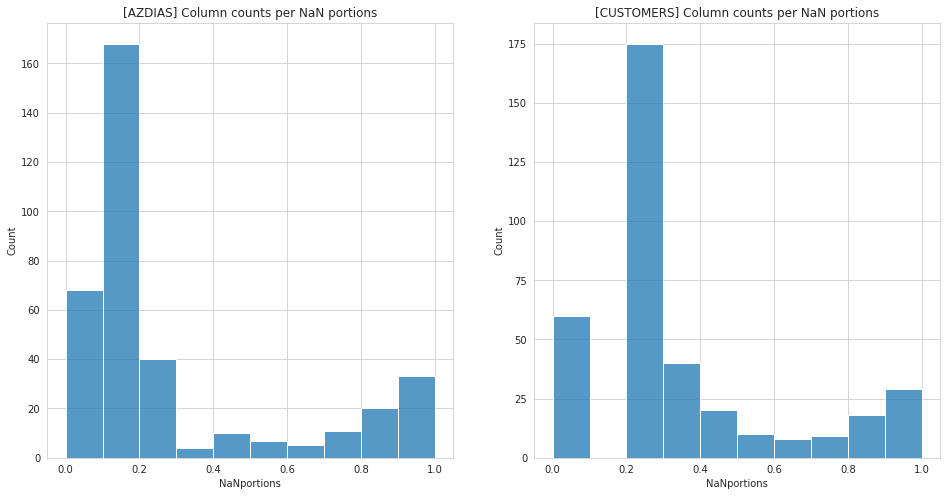

In [64]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1, 2, figsize=(16,8))
    sns.histplot(ax=ax[0], data=azdias_nans, x="NaNportions", bins=np.linspace(0, 1, 11)).set(title='[AZDIAS] Column counts per NaN portions')
    sns.histplot(ax=ax[1], data=cus_df_nans, x="NaNportions", bins=np.linspace(0, 1, 11)).set(title='[CUSTOMERS] Column counts per NaN portions')

We can see that both datasets have similar distributions of NaNs. The first plot for `azdias` shows that there are about 50+ attributes with NaNs above 80%. Around 280 attributes have less than 30% NaNs while the rest are between 30% - 80% NaNs. The second for `customers` shows that there are around 235 attributes with less than 30% NaNs and around 50 with more than 80% NaNs. We can confirm this with `value_counts`:

* `AZDIAS`


In [65]:
azd_col_nan_bins = azdias_nans.NaNportions.value_counts(bins=np.linspace(0, 1, 11), sort=False)

azd_col_nan_bins = azd_col_nan_bins.rename_axis("Bins").reset_index(name="Count")

azd_col_nan_bins["ColPortion"] = azd_col_nan_bins.Count / azdias.shape[1]

azd_col_nan_bins

,Bins,Count,ColPortion
0,"(-0.001, 0.1]",68,0.185792
1,"(0.1, 0.2]",168,0.459016
2,"(0.2, 0.3]",40,0.109290
3,"(0.3, 0.4]",4,0.010929
4,"(0.4, 0.5]",10,0.027322
5,"(0.5, 0.6]",7,0.019126
6,"(0.6, 0.7]",5,0.013661
7,"(0.7, 0.8]",11,0.030055
8,"(0.8, 0.9]",20,0.054645
9,"(0.9, 1.0]",33,0.090164


In [66]:
azd_col_nan_bins.loc[:2,].sum()

Count         276.000000
ColPortion      0.754098
dtype: float64

* `CUSTOMERS`

In [67]:
cus_col_nan_bins = cus_df_nans.NaNportions.value_counts(bins=np.linspace(0, 1, 11), sort=False)

cus_col_nan_bins = cus_col_nan_bins.rename_axis("Bins").reset_index(name="Count")

cus_col_nan_bins["ColPortion"] = cus_col_nan_bins.Count / custrs.shape[1]

cus_col_nan_bins

,Bins,Count,ColPortion
0,"(-0.001, 0.1]",60,0.162602
1,"(0.1, 0.2]",0,0.000000
2,"(0.2, 0.3]",175,0.474255
3,"(0.3, 0.4]",40,0.108401
4,"(0.4, 0.5]",20,0.054201
5,"(0.5, 0.6]",10,0.027100
6,"(0.6, 0.7]",8,0.021680
7,"(0.7, 0.8]",9,0.024390
8,"(0.8, 0.9]",18,0.048780
9,"(0.9, 1.0]",29,0.078591


In [68]:
cus_col_nan_bins.loc[:2,].sum()

Count         235.000000
ColPortion      0.636856
dtype: float64

####Format data for plotting

We need to convert the dataframe to [long-form](http://seaborn.pydata.org/tutorial/data_structure.html#long-form-vs-wide-form-data) to use the `hue` argument in `sns.barplot` to plot the data.

In [69]:
merge_col_nan_bins = pd.merge(azd_col_nan_bins, cus_col_nan_bins, on='Bins', suffixes=("_azd", "_cus"))

merge_col_nan_bins.head()

,Bins,Count_azd,ColPortion_azd,Count_cus,ColPortion_cus
0,"(-0.001, 0.1]",68,0.185792,60,0.162602
1,"(0.1, 0.2]",168,0.459016,0,0.000000
2,"(0.2, 0.3]",40,0.109290,175,0.474255
3,"(0.3, 0.4]",4,0.010929,40,0.108401
4,"(0.4, 0.5]",10,0.027322,20,0.054201


In [70]:
cols_nan_portns_melt = merge_col_nan_bins[['Bins', 'ColPortion_azd', 'ColPortion_cus']].melt(id_vars=('Bins'))
cols_nan_portns_melt.head()

,Bins,variable,value
0,"(-0.001, 0.1]",ColPortion_azd,0.185792
1,"(0.1, 0.2]",ColPortion_azd,0.459016
2,"(0.2, 0.3]",ColPortion_azd,0.109290
3,"(0.3, 0.4]",ColPortion_azd,0.010929
4,"(0.4, 0.5]",ColPortion_azd,0.027322


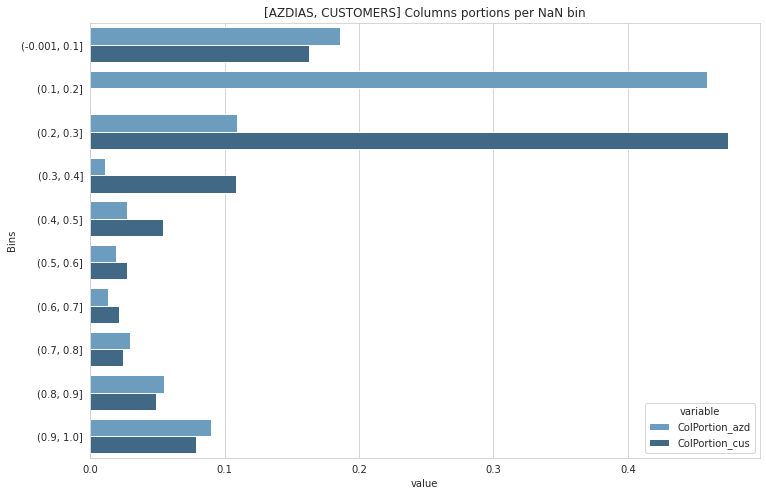

In [71]:
with sns.axes_style("whitegrid"):
    plt.figure(figsize=(12,8))
    sns.barplot(data=cols_nan_portns_melt, x="value", y="Bins", hue="variable", palette="Blues_d").set(title='[AZDIAS, CUSTOMERS] Columns portions per NaN bin')
    # sns.barplot(data=azd_col_nan_bins, x="ColPortion", y="Bins", color='royalblue').set(title='[AZDIAS] Columns portion per NaN bin')

###Rows NaNs analysis

* Identify missing values per row as percentage (portions).
* Drop rows with all NaNs (zero rows will be droppped):

In [72]:
def rows_nans_info(df, cols=None):
    """Return a new dataframe with NaNs summary per row of the input df

    Creates and returns a new dataframe with three columns that correspond to
    the rows of the input dataframe, the NaN counts per row
    and portion of NaNs per row.

    Args:
        df (pd.DataFrame): The input dataframe to process.
        cols (tuple): 3 elements tuple with the names of the three columns in the
        output dataframe. If left None the three default names ('Rows',
        'NaNcounts', 'NaNportions') will be used.
    
    Returns:
        A new dataframe with three columns providing counts and portions of NaNs
        per row in the input df. Examle:

            Rows    NaNcounts	NaNportions
        0	0	    685843	    0.769554
        1	1       73499	    0.082470
        2	2	    310267	    0.348137
        3	3	    810163	    0.909048
        4	4       861722	    0.966900
    """
    cols = cols or ('Rows', 'NaNcounts', 'NaNportions')
    new_df = df.isna().sum(axis=1).rename_axis(cols[0]).reset_index(name=cols[1])
    new_df[cols[2]] = new_df[cols[1]] / df.shape[1]

    print("Average NaNs per row: ", new_df[cols[2]].mean())
    print("Max NaNs per row: ", new_df[cols[2]].max())
    print("Min NaNs per row: ", new_df[cols[2]].min())

    return new_df

* `AZDIAS`

In [73]:
azdias_row_nans = rows_nans_info(azdias)

azdias_row_nans.NaNportions.describe()

Average NaNs per row:  0.2795126639344794
Max NaNs per row:  0.8579234972677595
Min NaNs per row:  0.07377049180327869


count    200000.000000
mean          0.279513
std           0.197230
min           0.073770
25%           0.183060
50%           0.213115
75%           0.243169
max           0.857923
Name: NaNportions, dtype: float64

* `CUSTOMERS`

In [74]:
custrs_row_nans = rows_nans_info(custrs)

custrs_row_nans.NaNportions.describe()

Average NaNs per row:  0.35495416064895896
Max NaNs per row:  0.8536585365853658
Min NaNs per row:  0.06775067750677506


count    191652.000000
mean          0.354954
std           0.286598
min           0.067751
25%           0.165312
50%           0.195122
75%           0.745257
max           0.853659
Name: NaNportions, dtype: float64

There is on average a 28% missing values per row in `AZDIAS` and around 35% NaNs per row in `CUSTOMERS`.

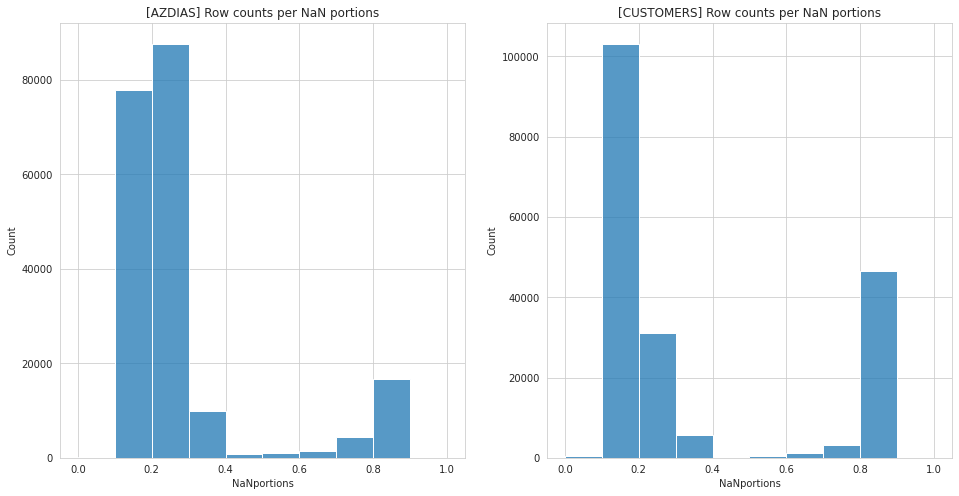

In [75]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1, 2, figsize=(16,8))
    sns.histplot(ax=ax[0], data=azdias_row_nans, x="NaNportions", bins=np.linspace(0, 1, 11)).set(title='[AZDIAS] Row counts per NaN portions')
    sns.histplot(ax=ax[1], data=custrs_row_nans, x="NaNportions", bins=np.linspace(0, 1, 11)).set(title='[CUSTOMERS] Row counts per NaN portions')

As seen both datasets have most rows with missing values in the range 10% - 30% per row.

* `AZDIAS`

In [76]:
azd_row_nan_bins = azdias_row_nans.NaNportions.value_counts(bins=np.linspace(0, 1, 11), sort=False)

azd_row_nan_bins = azd_row_nan_bins.rename_axis("Bins").reset_index(name="Count")

azd_row_nan_bins["RowPortion"] = azd_row_nan_bins.Count / azdias.shape[0]

azd_row_nan_bins

,Bins,Count,RowPortion
0,"(-0.001, 0.1]",170,0.000850
1,"(0.1, 0.2]",77806,0.389030
2,"(0.2, 0.3]",87716,0.438580
3,"(0.3, 0.4]",10009,0.050045
4,"(0.4, 0.5]",760,0.003800
5,"(0.5, 0.6]",1071,0.005355
6,"(0.6, 0.7]",1340,0.006700
7,"(0.7, 0.8]",4423,0.022115
8,"(0.8, 0.9]",16705,0.083525
9,"(0.9, 1.0]",0,0.000000


In [77]:
# 20% NaN counts and dataset poriton - AZDIAS
azd_row_nan_bins.loc[:2,].sum()

Count         165692.00000
RowPortion         0.82846
dtype: float64

* `CUSTOMERS`

In [78]:
cus_row_nan_bins = custrs_row_nans.NaNportions.value_counts(bins=np.linspace(0, 1, 11), sort=False)

cus_row_nan_bins = cus_row_nan_bins.rename_axis("Bins").reset_index(name="Count")

cus_row_nan_bins["RowPortion"] = cus_row_nan_bins.Count / custrs.shape[0]

cus_row_nan_bins

,Bins,Count,RowPortion
0,"(-0.001, 0.1]",327,0.001706
1,"(0.1, 0.2]",103171,0.538325
2,"(0.2, 0.3]",31178,0.162680
3,"(0.3, 0.4]",5563,0.029027
4,"(0.4, 0.5]",299,0.001560
5,"(0.5, 0.6]",327,0.001706
6,"(0.6, 0.7]",1079,0.005630
7,"(0.7, 0.8]",3071,0.016024
8,"(0.8, 0.9]",46637,0.243342
9,"(0.9, 1.0]",0,0.000000


In [79]:
# 20% NaN counts and dataset poriton - CUSTOMERS
cus_row_nan_bins.loc[:2,].sum()

Count         134676.000000
RowPortion         0.702711
dtype: float64

####Format data in long-form for plotting with `sns.barplot`. 

In [80]:
merge_row_nan_bins = pd.merge(azd_row_nan_bins, cus_row_nan_bins, on='Bins', suffixes=("_azd", "_cus"))

rows_nan_portns_melt = merge_row_nan_bins[['Bins', 'RowPortion_azd', 'RowPortion_cus']].melt(id_vars=('Bins'))

rows_nan_portns_melt.head()

,Bins,variable,value
0,"(-0.001, 0.1]",RowPortion_azd,0.000850
1,"(0.1, 0.2]",RowPortion_azd,0.389030
2,"(0.2, 0.3]",RowPortion_azd,0.438580
3,"(0.3, 0.4]",RowPortion_azd,0.050045
4,"(0.4, 0.5]",RowPortion_azd,0.003800


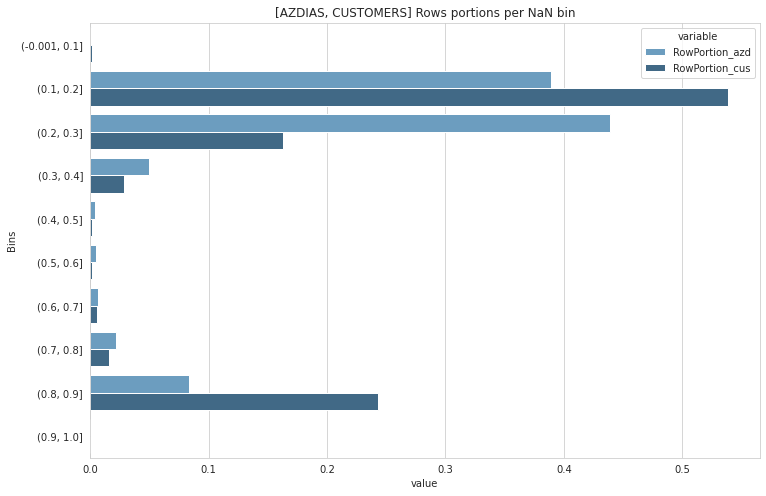

In [81]:
with sns.axes_style("whitegrid"):
    plt.figure(figsize=(12,8))
    sns.barplot(data=rows_nan_portns_melt, x="value", y="Bins", hue="variable", palette="Blues_d").set(title='[AZDIAS, CUSTOMERS] Rows portions per NaN bin')


In both datasets most rows have NaNs in the range 10% - 30%.


####Column type and exploration for the attributes with values range `'…'`

Finally we have the special cases where values' pool was `'…'`, described with the `attrs_val_dict_any` dictionary mapping. These include a wide range of numerical values:

* `AZDIAS`

In [82]:
# Check `attrs_val_dict_any` special cases types:
azdias.loc[:, attrs_val_dict_any.keys()].dtypes

ANZ_HAUSHALTE_AKTIV    float64
ANZ_HH_TITEL           float64
ANZ_PERSONEN           float64
ANZ_TITEL              float64
GEBURTSJAHR            float64
KBA13_ANZAHL_PKW       float64
MIN_GEBAEUDEJAHR       float64
dtype: object

In [83]:
azdias.loc[:, attrs_val_dict_any.keys()].describe()

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,GEBURTSJAHR,KBA13_ANZAHL_PKW,MIN_GEBAEUDEJAHR
count,177706.000000,5458.000000,175774.000000,691.000000,111962.000000,176269.000000,179151.000000
mean,8.416373,1.368450,1.800693,1.073806,1967.145264,617.631852,1993.299262
std,16.032139,1.424545,1.123983,0.282935,17.858062,338.716225,3.375281
min,1.000000,1.000000,1.000000,1.000000,1900.000000,1.000000,1985.000000
25%,2.000000,1.000000,1.000000,1.000000,1955.000000,381.000000,1992.000000
50%,4.000000,1.000000,1.000000,1.000000,1968.000000,547.000000,1992.000000
75%,10.000000,1.000000,2.000000,1.000000,1981.000000,777.000000,1993.000000
max,523.000000,23.000000,40.000000,3.000000,2017.000000,2300.000000,2016.000000


We may observe that values for the above attributes look acceptable.

In [84]:
# Count unique values per attribute (column)
azdias.loc[:, attrs_val_dict_any.keys()].nunique()

ANZ_HAUSHALTE_AKTIV     250
ANZ_HH_TITEL             18
ANZ_PERSONEN             18
ANZ_TITEL                 3
GEBURTSJAHR             115
KBA13_ANZAHL_PKW       1255
MIN_GEBAEUDEJAHR         32
dtype: int64

In [85]:
# Discrete unique values per column
azdias.loc[:, attrs_val_dict_any.keys()].apply(lambda col: col.unique())

ANZ_HAUSHALTE_AKTIV    [1.0, 40.0, 4.0, 7.0, 6.0, nan, 2.0, 5.0, 9.0,...
ANZ_HH_TITEL           [nan, 1.0, 2.0, 8.0, 3.0, 4.0, 6.0, 13.0, 7.0,...
ANZ_PERSONEN           [4.0, nan, 1.0, 2.0, 3.0, 5.0, 6.0, 7.0, 10.0,...
ANZ_TITEL                                           [nan, 1.0, 2.0, 3.0]
GEBURTSJAHR            [1994.0, 1921.0, nan, 2011.0, 1969.0, 1981.0, ...
KBA13_ANZAHL_PKW       [546.0, 311.0, 945.0, 482.0, 125.0, nan, 371.0...
MIN_GEBAEUDEJAHR       [1992.0, nan, 1997.0, 2009.0, 1996.0, 1988.0, ...
dtype: object

* `CUSTOMERS`

In [86]:
# Check `attrs_val_dict_any` special cases types:
custrs.loc[:, attrs_val_dict_any.keys()].dtypes

ANZ_HAUSHALTE_AKTIV    float64
ANZ_HH_TITEL           float64
ANZ_PERSONEN           float64
ANZ_TITEL              float64
GEBURTSJAHR            float64
KBA13_ANZAHL_PKW       float64
MIN_GEBAEUDEJAHR       float64
dtype: object

In [87]:
custrs.loc[:, attrs_val_dict_any.keys()].describe()

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,GEBURTSJAHR,KBA13_ANZAHL_PKW,MIN_GEBAEUDEJAHR
count,139275.000000,6088.000000,137910.000000,2740.000000,98628.000000,140371.000000,141725.000000
mean,5.053218,1.545171,2.385338,1.079562,1949.773127,667.231216,1993.056659
std,14.419710,2.130674,1.324283,0.288931,14.926854,340.481722,3.080241
min,1.000000,1.000000,1.000000,1.000000,1900.000000,5.000000,1985.000000
25%,1.000000,1.000000,1.000000,1.000000,1939.000000,430.000000,1992.000000
50%,1.000000,1.000000,2.000000,1.000000,1948.000000,593.000000,1992.000000
75%,4.000000,1.000000,3.000000,1.000000,1960.000000,828.000000,1992.000000
max,523.000000,23.000000,21.000000,5.000000,2017.000000,2300.000000,2016.000000


In [88]:
# Count unique values per attribute (column)
custrs.loc[:, attrs_val_dict_any.keys()].nunique()

ANZ_HAUSHALTE_AKTIV     215
ANZ_HH_TITEL             19
ANZ_PERSONEN             17
ANZ_TITEL                 4
GEBURTSJAHR             112
KBA13_ANZAHL_PKW       1250
MIN_GEBAEUDEJAHR         32
dtype: int64

In [89]:
# Discrete unique values per column
custrs.loc[:, attrs_val_dict_any.keys()].apply(lambda col: col.unique())

ANZ_HAUSHALTE_AKTIV    [1.0, nan, 7.0, 74.0, 9.0, 17.0, 12.0, 29.0, 2...
ANZ_HH_TITEL           [nan, 2.0, 4.0, 1.0, 13.0, 6.0, 5.0, 3.0, 20.0...
ANZ_PERSONEN           [2.0, 3.0, 1.0, nan, 4.0, 5.0, 6.0, 8.0, 7.0, ...
ANZ_TITEL                                      [nan, 1.0, 2.0, 3.0, 5.0]
GEBURTSJAHR            [nan, 1960.0, 1942.0, 1938.0, 1914.0, 1959.0, ...
KBA13_ANZAHL_PKW       [1201.0, nan, 433.0, 755.0, 513.0, 1167.0, 130...
MIN_GEBAEUDEJAHR       [1992.0, nan, 1994.0, 1997.0, 1995.0, 1996.0, ...
dtype: object

## One-hot encoding

In [90]:
azd_cp = pd.get_dummies(azdias)
cus_cp = pd.get_dummies(custrs)

In [91]:
# Match the columns in the dataframes
azd_cp, cus_cp = azd_cp.align(cus_cp, join = 'inner', axis = 1)
print('Azdias copy shape: ', azd_cp.shape)
print('Customers copy shape: ', cus_cp.shape)

Azdias copy shape:  (200000, 444)
Customers copy shape:  (191652, 444)


In [92]:
# Remove "LNR" and "EINGEFUEGT_AM" columns which are client IDs and entry datetimes

azd_cp.drop(columns=["LNR", "EINGEFUEGT_AM"], errors='ignore', inplace=True)
cus_cp.drop(columns=["LNR", "EINGEFUEGT_AM"], errors='ignore', inplace=True)

azd_cp.shape, cus_cp.shape

((200000, 442), (191652, 442))

irrelevant features, highly correlated features, and missing values can prevent the model from learning and decrease generalization performance on the testing data

## Feature selection to keep only the most useful attributes

* collinear attributes
(Ref: https://chrisalbon.com/code/machine_learning/feature_selection/drop_highly_correlated_features/)

Calculate correlation on a stratified sample of the data, since `azdias` dataframe is large enough that notebook runs out of memory while calculating the correlation matrix.

In [93]:
def get_stratified_samples(df, fracs=np.array([0.2, 0.8])):
    """Split an input df into two stratified sub-sets of sizes indicated
    by the fracs array.
    """
    # shuffle input df
    df_ = df.sample(frac=1) 
    # split into 2 parts, return df_smpl_a, df_smpl_b
    return np.array_split(df_, (fracs[:-1].cumsum() * len(df_)).astype(int))

azd_cp_smpl_a, azd_cp_smpl_b = get_stratified_samples(azd_cp)

azd_cp_smpl_a.shape, azd_cp_smpl_b.shape

((40000, 442), (160000, 442))

In [94]:
def drop_collinear_cols(df, threshold=0.95):
    """Ιdentifies the highly correlated variables based on the absolute
    magnitude of the Pearson correlation coefficient being greater than threshold (0.9)

    Args:
        df (pd.Dataframe): Input dataframe to work on
        threshold (float): threshold value above which the columns will selected
    
    Returns:
        np.array of selected collumns based on the threshold value.
    """
    # Calculate absolute value correlation matrix from the input df.
    corr_mat = df.corr().abs()
    # Select upper triangle of correlation matrix
    upr = corr_mat.where(np.triu(np.ones(corr_mat.shape), k=1).astype(np.bool))
    # Find index of attribute columns with correlation greater than `threshold`
    return np.array([c for c in upr.columns if any(upr[c] > threshold)])


In [95]:
# Find attribute columns with correlation greater than 0.95
to_drop_azd = drop_collinear_cols(azd_cp_smpl_a)

to_drop_azd, len(to_drop_azd)

(array(['ANZ_STATISTISCHE_HAUSHALTE', 'CAMEO_INTL_2015', 'D19_GARTEN',
        'D19_VERSAND_ONLINE_DATUM', 'GEBURTSJAHR', 'KBA13_HERST_SONST',
        'KBA13_KMH_250', 'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_FEIN',
        'LP_LEBENSPHASE_GROB', 'LP_STATUS_GROB', 'PLZ8_BAUMAX', 'PLZ8_GBZ',
        'PLZ8_HHZ', 'PRAEGENDE_JUGENDJAHRE', 'TITEL_KZ'], dtype='<U26'), 16)

We will do the same in the `CUSTOMERS` dataset to compare the attributes identified for dropping.

In [96]:
# CUSTOMERS
cus_cp_smpl_a, cus_cp_smpl_b = get_stratified_samples(cus_cp)

cus_cp_smpl_a.shape, cus_cp_smpl_b.shape

((38330, 442), (153322, 442))

In [97]:
# Find attribute columns with correlation greater than 0.95
to_drop_cus = drop_collinear_cols(cus_cp_smpl_a)

to_drop_cus, len(to_drop_cus)

(array(['ANZ_STATISTISCHE_HAUSHALTE', 'CAMEO_INTL_2015', 'GEBURTSJAHR',
        'KBA13_HERST_SONST', 'KBA13_KMH_250', 'LP_FAMILIE_GROB',
        'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_GROB',
        'PLZ8_GBZ', 'PLZ8_HHZ', 'PRAEGENDE_JUGENDJAHRE'], dtype='<U26'), 12)

Let's drop only the common ones identified in both datatsets' samples.

In [98]:
# to_drop = set(to_drop_azd).intersection(to_drop_cus)
to_drop = np.intersect1d(to_drop_azd, to_drop_cus)

to_drop, len(to_drop)

(array(['ANZ_STATISTISCHE_HAUSHALTE', 'CAMEO_INTL_2015', 'GEBURTSJAHR',
        'KBA13_HERST_SONST', 'KBA13_KMH_250', 'LP_FAMILIE_GROB',
        'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_GROB',
        'PLZ8_GBZ', 'PLZ8_HHZ', 'PRAEGENDE_JUGENDJAHRE'], dtype='<U26'), 12)

###Search more columns with high NaN ratio, check their significance.

References:
* https://www.kaggle.com/questions-and-answers/131935
* https://stats.stackexchange.com/questions/221332/variance-of-a-distribution-of-multi-level-categorical-data

Check attributes with NaN ration more than **0.8**.

In [99]:
# Select the columns with NaNs more than 80% to check for variabiltiy
azdias_nans_gt80 = azdias_nans.loc[(azdias_nans["NaNportions"] > .8) & (azdias_nans["NaNportions"] < 1.0), "Columns"].values

azdias_nans_gt80, azdias_nans_gt80.size

(array(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4',
        'ANZ_HH_TITEL', 'ANZ_KINDER', 'ANZ_TITEL', 'D19_BANKEN_ANZ_12',
        'D19_BANKEN_ANZ_24', 'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS',
        'D19_BANKEN_LOKAL', 'D19_BANKEN_ONLINE_QUOTE_12',
        'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BILDUNG',
        'D19_BIO_OEKO', 'D19_DIGIT_SERV', 'D19_DROGERIEARTIKEL',
        'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN', 'D19_HANDWERK',
        'D19_HAUS_DEKO', 'D19_KINDERARTIKEL', 'D19_KOSMETIK',
        'D19_LEBENSMITTEL', 'D19_LOTTO', 'D19_NAHRUNGSERGAENZUNG',
        'D19_RATGEBER', 'D19_REISEN', 'D19_SAMMELARTIKEL', 'D19_SCHUHE',
        'D19_SOZIALES', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24',
        'D19_TELKO_MOBILE', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_TELKO_REST',
        'D19_TIERARTIKEL', 'D19_VERSAND_REST', 'D19_VERSI_ANZ_12',
        'D19_VERSI_ANZ_24', 'D19_VERSI_ONLINE_QUOTE_12',
        'D19_WEIN_FEINKOST', 'GREEN_AVANTGARDE', 'HH_DELTA_FLAG',
   

In [100]:
# Filter `azdias` dataset to select the above columns only.
# azdias_var_nan80 = azdias.filter(azdias_nans_gt80)

# azdias_var_nan80.dtypes.value_counts()

azdias.filter(azdias_nans_gt80).dtypes.value_counts()

float64    53
dtype: int64

We will calculate the entropy on the above (ordinal variables) as a measure of the amount of information in a categorical variable. We will attempt to identify columns with little to no information at all.

To do this we will create a function to calculate the entropy in a given column.

In [101]:
def get_entropy(labels):
    """Calculate the entropy of a data series.

    Calculate the entropy based on Shannon's entropy (log2).
    Scipy entropy() will normalize values' frequencies if
    they don’t sum to 1.

    Args:
        labels (pd.Series): pandas Series to calculate entropy
    
    Returns:
        ent: The calculated entropy of the input labels
    """
    # get values' frequencies
    vals_freq = labels.value_counts(sort=False)
    ent = entropy(vals_freq, base=2)
    
    return ent

A mapping of attribute names (columns) and entropy can be created. This will allow us to decide if we should drop some more columns with high percentage of NaNs that also offer little to no information.

In [102]:
def drop_nan_cols(df, df_nans_cols, nan_thres=.8, use_entropy=True, ent_thres=1.0):
    """Get df columns with higher NaN percent than  nan_thres (> 80%) and return
    the ones with entropy < ent_thres. If use_entropy=False return all columns
    with NaN portion higher than nan_thres.

    Returns:
        drop_cols (np.array): Highr percentage NaN columns list (with low entropy)
        ent (dict): Mapping of attributes names with entropy values for selected
        columns range (or None if entropy not used). 
    """
    # Select the columns with NaNs more than nan_thres to check for variabiltiy
    df_nans_cols_gt80 = df_nans_cols.loc[
                                         (df_nans_cols["NaNportions"] > nan_thres) & \
                                         (df_nans_cols["NaNportions"] < 1.0),
                                         "Columns"].values
    # Filter the dataset to select the above columns only.
    df_var_nan80 = df.filter(df_nans_cols_gt80)
    drop_cols = df_var_nan80.values
    ent = None
    if use_entropy:
        # Calculate entropy & create maping
        ent = {i: round(get_entropy(df_var_nan80[i]), 4) for i in df_var_nan80}
        # From the dictionary we will select the columns with entropy less than ent_thres
        df_ent_drop = [i for i in ent if ent[i] < ent_thres]
        drop_cols = np.array(df_ent_drop)

    return drop_cols, ent


In [103]:
# Get azdias columns with higher NaN percent (> 80%) and return the ones with entropy < 1.0
azd_ent_drop, azdias_var_nan80_ent = drop_nan_cols(azdias, azdias_nans)

azd_ent_drop, len(azd_ent_drop)

(array(['ANZ_HH_TITEL', 'ANZ_TITEL', 'D19_BANKEN_ONLINE_QUOTE_12',
        'D19_LOTTO', 'D19_TELKO_ONLINE_QUOTE_12',
        'D19_VERSI_ONLINE_QUOTE_12', 'GREEN_AVANTGARDE', 'HH_DELTA_FLAG',
        'KBA05_ANTG4', 'KBA05_SEG6', 'SOHO_KZ', 'TITEL_KZ',
        'UNGLEICHENN_FLAG'], dtype='<U26'), 13)

Check if there are any attributes in common with the ones selected with the correlation matrix method (`to_drop`)

In [104]:
np.intersect1d(np.array(to_drop), azdias_nans_gt80)

array([], dtype=object)

In [105]:
np.intersect1d(to_drop, azd_ent_drop)

array([], dtype='<U26')

In [106]:
# Create plot data, in a new df get 'Attributes', 'Entropy' and "NaNportions"
plt_data = pd.DataFrame(azdias_var_nan80_ent.items(), columns=['Attributes', 'Entropy'])

# Get NaN portions for the attributes with NaNs more than 80%
plt_data["NaNportions"] = azdias_nans.loc[azdias_nans["Columns"].isin(azdias_nans_gt80), "NaNportions"].values

# Sort by `Entropy` values
plt_data.sort_values("Entropy", ascending=False, inplace=True)

plt_data.head()

,Attributes,Entropy,NaNportions
0,ALTER_KIND1,3.8847,0.908205
1,ALTER_KIND2,3.5787,0.966860
2,ALTER_KIND3,3.2763,0.993340
3,ALTER_KIND4,2.9943,0.998670
18,D19_DROGERIEARTIKEL,2.4315,0.854025


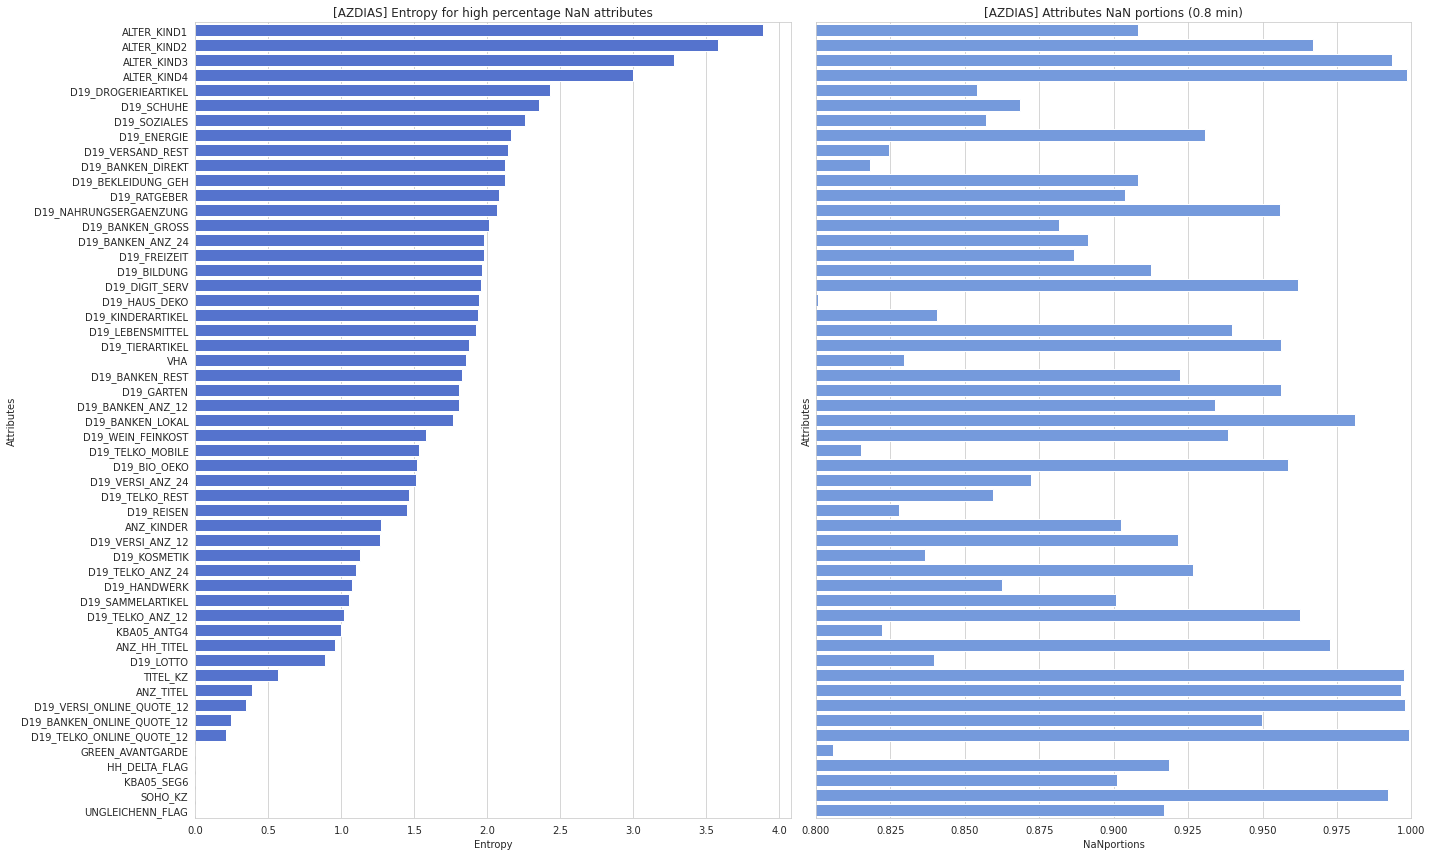

In [107]:
# Let's visualize the results
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1, 2, figsize=(20,12), sharey=True)
    sns.barplot(ax=ax[0], data=plt_data, x='Entropy', y='Attributes', color='royalblue').set(title='[AZDIAS] Entropy for high percentage NaN attributes')
    sns.barplot(ax=ax[1], data=plt_data, x='NaNportions', y='Attributes', color='cornflowerblue').set(title='[AZDIAS] Attributes NaN portions (0.8 min)', xlim=(0.8,1.0))
    fig.tight_layout()


Plots show that some of the attributes found with the lowest entropy also have a high number of NaNs. Checking entropy as a measure of information per column will allow us to drop those columns with high percentage of NaNs, with more confidence than just choosing to drop columns above a high NaN percentage threshold.

###Drop previously selected attributes

* Drop collinear attributes in `to_drop` array.
* Drop attributes in `azd_ent_drop` with NaNs more than 80%, also identified with the lowest entropy among the rest with such high NaN percentage.
* Drop `CUSTOMERS` specific attributes (`'CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'`).
* Drop the client ID attribute `'LNR'` and datetime ``.

In [108]:
# Create unique, array of attributes that are in input arrays.
other_to_drop = ["LNR", "EINGEFUEGT_AM", "CUSTOMER_GROUP", "ONLINE_PURCHASE", "PRODUCT_GROUP"]

# Using functools.reduce to find the union of the three arrays
to_drop = reduce(np.union1d, (to_drop, azd_ent_drop, other_to_drop))

# Drop attributes in both datasets
azdias.drop(columns=to_drop, errors='ignore', inplace=True)
custrs.drop(columns=to_drop, errors='ignore', inplace=True)

azdias.shape, custrs.shape

((200000, 339), (191652, 339))

In [109]:
def wrangle_df(df, val_pools, common_attrs, replace_nan):
    """Clean and fix an input demographics dataframe for this project.

    This function is for cleaning and fixing datasets for this project. It
    returns a clean dataframe with several columns dropped based on identified
    NaNs, entropy and  collinearity. Additionally, value per column are checked
    and replaced with NaNs if they fall outside an accepted values pool.

    Args:
        df (pd.Dataframe): Input demographics datafrme (The notebook crashes when
        the entire `azdias` is loaded).
        val_pools (dict): A dictionary with keys the attributes names and values
        lists with the allowed values for each attribute. e.g.:
        {'AGER_TYP': [nan, -1, 0, 1, 2, 3], ...}
        common_attrs (np.array): Common attributes (attrs_common) between
        demographic dataset and excel files. e.g.:
        (array(['AKT_DAT_KL', 'ALTERSKATEGORIE_FEIN', ...)]
        replace_nan (dict): Mapping of attributes and values to replace with NaNs
        within each attribute. e.g. {'AGER_TYP': 9} will replace 9 in 'AGER_TYP'
        with NaN.
    
    Returns:
        df (pd.Dataframe), clientIDs (pd.Series), dates (pd.Series):
        The cleaned and fixed df, client IDs extracted, entry dates extracted.
    """
    
    # find object columns
    cat_cols = df.select_dtypes(include=object).columns.tolist()
    # Convert to category columns using astype method
    df[cat_cols] = df[cat_cols].astype('category')

    # Replace unkown and specific values with NaNs
    # for every key (attribute) in the dictionary created earlier
    for k in val_pools:
        # if the attribute is among the common ones
        if k in common_attrs:
            # select all those rows in the column that fall outside the attritbute's specified values pool and replace them with NaN.
            df.loc[~df[k].isin(val_pools[k]), k] = np.NaN
    # Use a dictionary mapping of attributes to replace value 9 (unknown) for NaN for specifc attributes.
    df.replace(replace_nan, np.NaN, inplace=True)

    # NaNs
    # Total
    df_nan = df.isna().sum().sum()
    print("Total df NaNs portion: ", round(df_nan/df.size, 4))
    # Columns
    print("Column NaNs:")
    df_cols_nans = cols_nans_info(df)
    # Rows
    print("Row NaNs:")
    df_rows_nans = rows_nans_info(df)

    # Keep the LNR and EINGEFUEGT_AM dates columns separately.
    # clientIDs = df["LNR"]
    # dates = df["EINGEFUEGT_AM"]

    # Create two stratified samples of the input dataframe.
    df_a, df_b = get_stratified_samples(df)

    # Find attribute columns with correlation greater than 0.95, using the smaller sized df_a
    corr_cols_to_drop = drop_collinear_cols(df_a)

    # Select the columns with NaNs more than 80% and with entropy less than 1.0.
    df_ent_drop, ent = drop_nan_cols(df, df_cols_nans)

    # Create unique, array of attributes that are in input arrays.
    # other_to_drop = np.array(["LNR", "EINGEFUEGT_AM", "CUSTOMER_GROUP", "ONLINE_PURCHASE", "PRODUCT_GROUP"])
    other_to_drop = np.array(["CUSTOMER_GROUP", "ONLINE_PURCHASE", "PRODUCT_GROUP"])

    # Using functools.reduce to find the union of the three arrays
    to_drop = reduce(np.union1d, (corr_cols_to_drop, df_ent_drop, other_to_drop))

    # Drop attributes
    df.drop(columns=to_drop, errors='ignore', inplace=True)

    return df  #, clientIDs, dates

In [117]:
def create_train_test(dfs, read_csv_kwargs, wrangle_args):
    """Prepare data from two demographic type datesets. One dataset is contains
    verified entries while the other not. `Target` columns are created and added
    to the datasets which are cleaned and concatanated. Returns train, target
    sets and the initial subsets cleaned.

    Returns:
        df_s (dict): Features and test features dataframes in the form
            {'azdias': pd.DataFrame, 'customers': pd.DataFrame}
    """
    # 1. Read samples and wrangle data
    df_s = {}
    for k in dfs:
        print("Dataframe [" + k.upper() + "]")
        df_s[k] = get_df_sample(dfs[k][1], None, dfs[k][0], **read_csv_kwargs)
        df_s[k] = wrangle_df(df_s[k], *wrangle_args)
        print(25*"-")

    # 2. Create `TARGET` attributes
    df_s = {k: df_s[k].assign(TARGET=1 if k == 'customers' else 0) for k in df_s}
    
    return df_s

    # # 2. Create a new df concatenating the dfs also creating a `target` attribute "customer"
    # df_ = pd.concat([df_s[k][0].assign(customer=1 if k == 'customers' else 0) for k in df_s])

    # # 3. One-hot encoding
    # df_ = pd.get_dummies(df_)

    # # 4. Create train, target
    # X = df_.drop(columns="customer")
    # Y = df_["customer"]

    # return (X, Y), df_s
    # Split into training and larger test sets (this can be split to create validation sets)
    # return train_test_split(X, Y, stratify=Y, **train_test_args)

# dfs dictionary of the form: {'filename': 'sample_size'}
dfs_comb = {
    'azdias': (azdias_file, 100000),
    'customers': (customers_file, 100000),
}

# `read_csv` parameters dictionary
read_csv_kwargs = {
    'sep': ';',
    'na_values': na_tupl,
    'chunksize': 256000,
    'parse_dates': ['EINGEFUEGT_AM'],
}

# `wrangle_df` parameters tuple
wrangle_args = (attrs_val_pools, attrs_common, replace9_nan_dict)

# `train_test_split` parameters dictionary
train_test_args = {
    'test_size': .3,
    'random_state': 42,
}

In [ ]:
# Get an initial train-test split 70-30 to allow splitting the data again for validation sets.
# X_train, X_test, Y_train, Y_test = create_train_test(dfs_comb, read_csv_kwargs, wrangle_args, train_test_args)
train_test_dfs = create_train_test(dfs_comb, read_csv_kwargs, wrangle_args)

Dataframe [AZDIAS]
Total df NaNs portion:  0.2793
Column NaNs:
Average NaNs per column:  0.27931885245901666
Max NaNs per column:  0.9991
Min NaNs per column:  0.0
Row NaNs:
Average NaNs per row:  0.27931885245898086
Max NaNs per row:  0.8579234972677595
Min NaNs per row:  0.07377049180327869
-------------------------
Dataframe [CUSTOMERS]
Total df NaNs portion:  0.3559
Column NaNs:
Average NaNs per column:  0.355868509485096
Max NaNs per column:  0.99906
Min NaNs per column:  0.0
Row NaNs:
Average NaNs per row:  0.3558685094850899
Max NaNs per row:  0.8536585365853658
Min NaNs per row:  0.07859078590785908
-------------------------


In [ ]:
len(X_train), len(X_test)

(140000, 60000)

In [ ]:
def run_lgb_model(features, test_features, n_folds = 5):
    """Train and test a light gradient boosting model using
    cross validation. 
    
    Args:
        features (pd.DataFrame): dataframe of training features to use for
            training a model. Must include the `TARGET` column.
        test_features (pd.DataFrame): dataframe of testing features to use for
            making predictions with the model. 
        n_folds (int, default = 5): number of folds to use for cross validation
        
    Returns:
        submission (pd.DataFrame): dataframe with `SK_ID_CURR` and `TARGET`
            probabilities predicted by the model.
        feature_importances (pd.DataFrame): dataframe with the feature
            importances from the model.
        valid_metrics (pd.DataFrame): dataframe with training and validation
            metrics (ROC AUC) for each fold and overall.
    
    Ref: https://www.kaggle.com/willkoehrsen/introduction-to-feature-selection#Remove-Collinear-Variables
    """
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    
    # One Hot Encoding ------->
    features = pd.get_dummies(features)
    test_features = pd.get_dummies(test_features)
    
    # Align the dataframes by the columns
    features, test_features = features.align(test_features, join = 'inner', axis = 1)
    
    # No categorical indices to record
    cat_indices = 'auto'
    # <-------
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = False, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', boosting_type='goss',
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, n_jobs = -1, random_state = 50)
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics

In [ ]:
del df_lgb

LGB plottin and interpretation:
* https://stackoverflow.com/questions/61862597/how-to-get-variance-explained-of-features-for-lightgbm-model
* https://stackoverflow.com/questions/53413701/feature-importance-using-lightgbm

###KFOLDS

* https://scikit-learn.org/stable/modules/cross_validation.html#k-fold

ROC_AUC_SCORE
* https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics


In [111]:
# Create a new dataframe from `azdias` and `customers` dataframes creating a `target` attribute "customer":
df_lgb = pd.concat([azdias.assign(customer=0), custrs.assign(customer=1)])

df_lgb.shape

(391652, 340)

In [113]:
azdias.shape, custrs.shape

((200000, 339), (191652, 339))

In [ ]:
# get a sample of customers same size as azdias
# custrs_sub = custrs.sample(sample_size, random_state=42)

# train = pd.get_dummies(azdias)
# train_labels = pd.get_dummies(custrs_sub)

# train.fillna(0,inplace=True)
# train_labels.fillna(0,inplace=True)

# custrs_lgb = custrs.assign(customer=1)
# custrs_lgb = pd.get_dummies(custrs_lgb)

In [ ]:
# train, train_labels = train.align(train_labels, join = 'inner', axis = 1)

In [ ]:
df_lgb.dtypes.value_counts()

float64    332
int64        6
object       3
dtype: int64

In [114]:
df_lgb = pd.get_dummies(df_lgb)

In [ ]:
# transfer numeric columns as float
# numeric_cols_to_transform = df_lgb.select_dtypes(include='int64').columns

# df_lgb[numeric_cols_to_transform] = df_lgb[numeric_cols_to_transform].fillna(0)

# for col in numeric_cols_to_transform:
#     df_lgb[col] = df_lgb[col].astype('float')


In [ ]:
#object cols
# obj_cols_to_transform = df_lgb.select_dtypes(include='object').columns

# # transfer object columns as category cols
# for col in obj_cols_to_transform:
#     df_lgb[col] =  df_lgb[col].astype('category').cat.codes

In [ ]:
del target, train

In [115]:
train = df_lgb.drop(columns="customer")
target = df_lgb["customer"]

train.shape

(391652, 417)

In [116]:
# Initialize an empty array to hold feature importances of size equal to current attributes size
feature_importances = np.zeros(train.shape[1])

# Create the model with several hyperparameters
# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')

In [ ]:
# Fit the model twice to avoid overfitting
for i in range(2):
    
    # Split into training and validation sets
    train_features, valid_features, train_y, valid_y = train_test_split(train, target, test_size = 0.25, random_state = i)
    
    # Train using early stopping
    model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], 
              eval_metric = 'auc', verbose = 200)
    
    # Record the feature importances
    feature_importances += model.feature_importances_

Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.326042	valid_0's auc: 0.934257
Early stopping, best iteration is:
[131]	valid_0's binary_logloss: 0.324718	valid_0's auc: 0.934624
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.324614	valid_0's auc: 0.934795
Early stopping, best iteration is:
[113]	valid_0's binary_logloss: 0.323476	valid_0's auc: 0.935234


In [ ]:
# Make sure to average feature importances! 
feature_importances = feature_importances / 2
feature_importances = pd.DataFrame({'feature': list(train.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)

feature_importances.head()

,feature,importance
60,D19_SOZIALES,188.5
7,ALTERSKATEGORIE_FEIN,127.0
286,LP_FAMILIE_FEIN,115.0
1,AKT_DAT_KL,106.5
336,ALTERSKATEGORIE_GROB,69.0


In [ ]:
# Find the features with zero importance
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])

print('There are %d features with 0.0 importance' % len(zero_features))

feature_importances.tail()

There are 24 features with 0.0 importance


,feature,importance
395,D19_LETZTER_KAUF_BRANCHE_D19_HANDWERK,0.0
357,CAMEO_DEU_2015_5C,0.0
387,D19_LETZTER_KAUF_BRANCHE_D19_BILDUNG,0.0
342,CAMEO_DEU_2015_2A,0.0
39,D19_FREIZEIT,0.0


In [ ]:
def plot_feature_importances(df, threshold = 0.9):
    """
    Plots 15 most important features and the cumulative importance of features.
    Prints the number of features needed to reach threshold cumulative importance.
    
    Parameters
    --------
    df : dataframe
        Dataframe of feature importances. Columns must be feature and importance
    threshold : float, default = 0.9
        Threshold for prining information about cumulative importances
        
    Return
    --------
    df : dataframe
        Dataframe ordered by feature importances with a normalized column (sums to 1)
        and a cumulative importance column
    
    """
    
    plt.rcParams['font.size'] = 18
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df

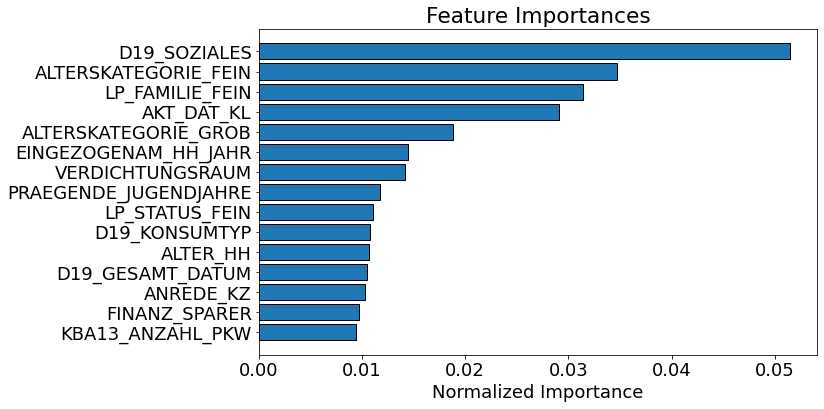

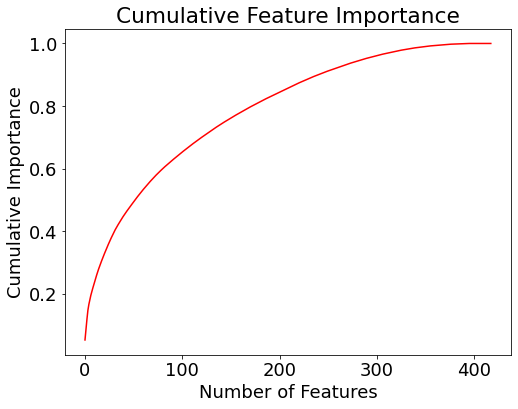

241 features required for 0.90 of cumulative importance


In [ ]:
norm_feature_importances = plot_feature_importances(feature_importances)

Let's remove the features that have zero importance.

In [ ]:
train.drop(columns=zero_features, errors='ignore', inplace=True)

train.shape

(391652, 394)

In [ ]:
len(zero_features)

21

In [ ]:
def identify_zero_importance_features(train, target, iterations = 2):
    """
    Identify zero importance features in a training dataset based on the 
    feature importances from a gradient boosting model. 
    
    Parameters
    --------
    train : dataframe
        Training features
        
    target : np.array
        Labels for training data
        
    iterations : integer, default = 2
        Number of cross validation splits to use for determining feature importances
    """
    
    # Initialize an empty array to hold feature importances
    feature_importances = np.zeros(train.shape[1])

    # Create the model with several hyperparameters
    model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')
    
    # Fit the model multiple times to avoid overfitting
    for i in range(iterations):

        # Split into training and validation set
        train_features, valid_features, train_y, valid_y = train_test_split(train, target, test_size = 0.25, random_state = i)

        # Train using early stopping
        model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], 
                  eval_metric = 'auc', verbose = 200)

        # Record the feature importances
        feature_importances += model.feature_importances_ / iterations
    
    feature_importances = pd.DataFrame({'feature': list(train.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)
    
    # Find the features with zero importance
    zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
    print('\nThere are %d features with 0.0 importance' % len(zero_features))
    
    return zero_features, feature_importances

In [ ]:
second_round_zero_features, feature_importances = identify_zero_importance_features(train, target)

Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.325638	valid_0's auc: 0.934349
Early stopping, best iteration is:
[131]	valid_0's binary_logloss: 0.324718	valid_0's auc: 0.934624
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.324855	valid_0's auc: 0.934735
Early stopping, best iteration is:
[109]	valid_0's binary_logloss: 0.323444	valid_0's auc: 0.935227

There are 3 features with 0.0 importance


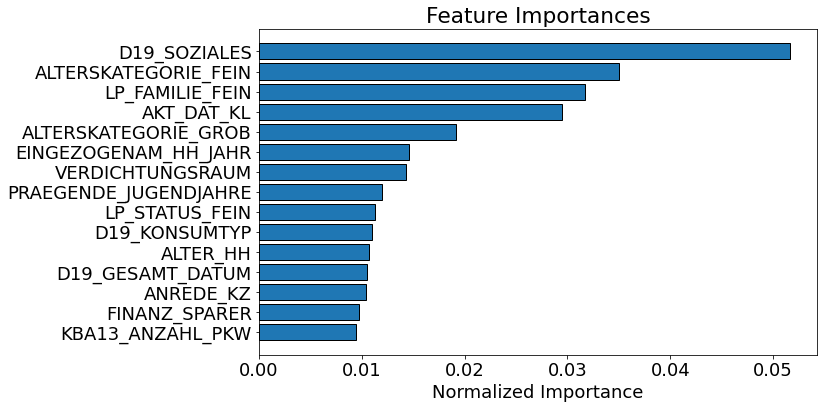

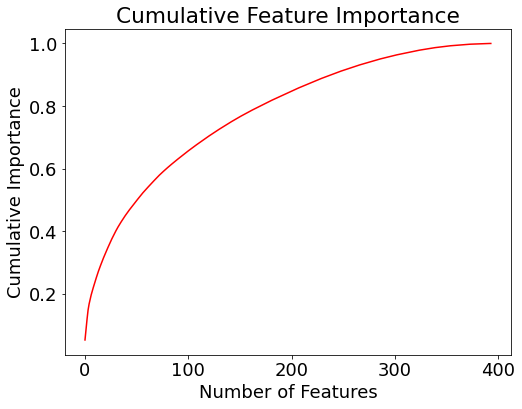

287 features required for 0.95 of cumulative importance


In [ ]:
norm_feature_importances = plot_feature_importances(feature_importances, threshold = 0.95)

In [ ]:
# Threshold for cumulative importance
threshold = 0.95

# Extract the features to keep
features_to_keep = list(norm_feature_importances[norm_feature_importances['cumulative_importance'] < threshold]['feature'])

# Create new datasets with smaller features
train_small = train[features_to_keep]


In [ ]:
train_small["customer"] = target

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
train_small.to_csv('/content/drive/MyDrive/workspace/arvato_data/m_train_small.csv', index = False)

An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters:

* True Positive Rate
* False Positive Rate

AUC measures the entire two-dimensional area underneath the entire ROC curve  from (0,0) to (1,1). AUC provides an aggregate measure of performance across all possible classification thresholds.

* AUC is scale-invariant. It measures how well predictions are ranked, rather than their absolute values.
* AUC is classification-threshold-invariant. It measures the quality of the model's predictions irrespective of what classification threshold is chosen.

In [ ]:
def kaggle_submit(filename, message, competition, data):
    """Prepare data, export to csv file and submit to kaggle competition.
    Args:
        filename (srt): name of the csv file to submit and write to
        message (srt): message related to submission
        competition (srt): the name of kaggle competition to submit 
        data (dict): submission data in dictionary form e.g.
        {"LNR": pd.Series, "RESPONSE": pd.Series}
    Returns:
        (str): Submission results
    """
    # kaggle competition: udacity-arvato-identify-customers
    # Kaggle competition invitation: http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140
    kg_api = KaggleApi()
    kg_api.authenticate()

    submit = pd.DataFrame(data)
    submit.to_csv(filename, index=False)

    return kg_api.competition_submit(filename, message, competition)

# kaggle_submit(kg_submission + "lgbm_test", kg_competition, 'lgbm 1st submission', )

In [ ]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
#mailout_train = pd.read_csv(mailout_train_file, sep=';')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
#mailout_test = pd.read_csv(mailout_test_file, sep=';')